# OCR & Deep Learning

- **Credit**: [nanonets](https://nanonets.com/) & [mindee](https://mindee.com/)
- **Notebook Author**: [Pierre GUILLOU](https://www.linkedin.com/in/pierreguillou/)
- **Version & Date**: v1.2: 12/10/2021 (v1.1: 02/10/2021 - v1: 01/10/2021)
- **Blog post**: [NLP nas empresas | Reconhecimento de textos com Deep Learning em PDFs e imagens](https://medium.com/@pierre_guillou/nlp-nas-empresas-reconhecimento-de-textos-com-deep-learning-em-pdfs-e-imagens-14d8b9e8d513)

Todas as empresas têm uma coisa em comum: usam e produzem muitos documentos em formatos como PDF ou imagem que dificultam sua análise por modelos de NLP de tipo NER (Named Entity Recognition), por exemplo. Felizmente, as ferramentas de OCR (Optical character recognition) progrediram enormemente, em particular desde 2018 com o uso de modelos de Deep Learning para a detecção e reconhecimento de textos. 

Se [Tesseract](https://github.com/tesseract-ocr/tesseract) é a ferramenta Open Source mais conhecida, e existem outras ferramentas como o [DocTR](https://github.com/mindee/doctr) que também merecem ser testadas quanto à sua facilidade de uso e eficiência graças ao Deep Leanring.

In [1]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Tesseract

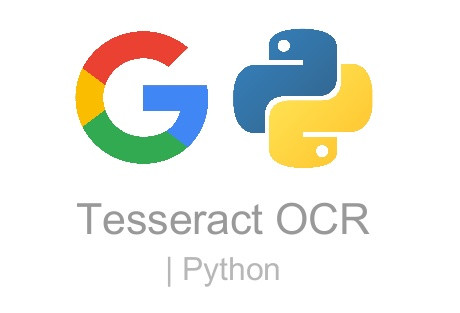

[Tesseract](https://github.com/tesseract-ocr/tesseract) is an optical character recognition engine for various operating systems. It is free software, released under the Apache License. Originally developed by Hewlett-Packard as proprietary software in the 1980s, it was released as open source in 2005 and development has been [sponsored by Google since 2006](http://googlecode.blogspot.com/2006/08/announcing-tesseract-ocr.html). 

Version 4 adds [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) based OCR engine and models for many additional languages and scripts, bringing the total to 116 languages.

**Note**: we will use parts of the post [A comprehensive guide to OCR with Tesseract, OpenCV and Python](https://nanonets.com/blog/ocr-with-tesseract/) in this notebook.

### Installation

#### PyTesseract 

Check your Ubuntu version.

In [ ]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic


For `Ubuntu 18.04` users, Tesseract 4 is part of the main `apt-get` repository. Thanks to that, it is easy to install Tesseract via command `sudo apt install tesseract-ocr`. 

After that, we should install the lang package corresponding to the language of our text (if not English). I will leave in comments the commands to run but it is far more easy to run just one command `sudo apt-get install tesseract-ocr-LANG` replacing LANG by the 3 letters of the lang package. For example, for Portuguese, run the command `sudo apt-get install tesseract-ocr-por` (check the [Tesseract languages list](https://github.com/tesseract-ocr/tessdoc/blob/main/Data-Files-in-different-versions.md) and the corresponding files [here](https://github.com/tesseract-ocr/tessdata) if you want to install them manually).

At last, install PyTesseract (the python wrapper for Tesseract) with the command `pip install pytesseract`.

In [ ]:
%%capture
!sudo apt update

# tesseract-ocr
# !sudo apt install tesseract-ocr
!sudo apt-get install tesseract-ocr-por

# pytesseract
!pip install pytesseract

In [ ]:
# Verify your Tesserac version
# As long as you see tesseract 4 somewhere in the output,
# you know that you have the latest version of Tesseract installed on your system.
!tesseract -v

tesseract 4.0.0-beta.1
 leptonica-1.75.3
  libgif 5.1.4 : libjpeg 8d (libjpeg-turbo 1.5.2) : libpng 1.6.34 : libtiff 4.0.9 : zlib 1.2.11 : libwebp 0.6.1 : libopenjp2 2.3.0

 Found AVX2
 Found AVX
 Found SSE


In [ ]:
# check lang packages
!tesseract --list-langs

List of available languages (3):
eng
por
osd


#### (Option) Lang

If you installed Tesseract via the command `sudo apt install tesseract-ocr`, we need to install manually a lang package. 

Check the languages supported by Tesseract [here](https://github.com/tesseract-ocr/tessdoc/blob/main/Data-Files-in-different-versions.md).

Then, find the url of the language you want to use within Tesseract [here](https://github.com/tesseract-ocr/tessdata).

For example, if you want to use Portuguese, use this link https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata to download the lang package inside the `tessdata` folder.

In [ ]:
# tessdatadir = '/usr/share/tesseract-ocr/4.00/tessdata'
# %cd {tessdatadir}

# # %%capture
# !wget https://github.com/tesseract-ocr/tessdata/raw/4.00/por.traineddata
# %cd /content

# # chack lang
# !tesseract --list-langs

#### pdf2image & OpenCV

Now that we have the PyTesseract, we now need to install OpenCV.

In [ ]:
%%capture
# Install following libraries if necessary 

# Pillow
# Pillow is the friendly PIL (Python Imaging Library). 
# PIL adds image processing capabilities to your Python interpreter.
# !pip install pillow

# imutils
# https://github.com/PyImageSearch/imutils
# A series of convenience functions to make basic image processing functions such as translation, rotation, resizing, skeletonization, 
# and displaying Matplotlib images easier with OpenCV and both Python 2.7 and Python 3.
# !pip install imutils

# pdf2image
# A python (3.6+) module that wraps pdftoppm and pdftocairo to convert PDF to a PIL Image object
!apt-get install poppler-utils 
!pip install pdf2image

# OpenCV
# OpenCV (Open Source Computer Vision Library) is an open source computer vision and machine learning software library. 
!sudo apt update
!sudo apt install python3-opencv

In [ ]:
import cv2
print(cv2.__version__)

4.5.3


In [ ]:
# In Colab, use cv2_imshow instead of cv2.imshow
from google.colab.patches import cv2_imshow

### OCR with Pytesseract and OpenCV

Let's test Tesseract with an image and a PDF.

**Note**: as we will convert PDF to image, the Tesseract method on PDF is the same as the one on image.

#### 1. Image

Let's analyze one image about COVID-19 in Portuguese language (from Fiocruz).

In [ ]:
import cv2
import pytesseract
import numpy as np

# path to image
# source: https://portal.fiocruz.br/coronavirus/material-para-download
path_to_data = "/content/drive/MyDrive/Colab Notebooks/PDF_with_DL/data/"
doc_name = "atencao_com_as_mascaras_de_tecido_2_0_0.jpg"
path_to_doc = path_to_data + doc_name

# get OpenCV image
img = cv2.imread(path_to_doc)

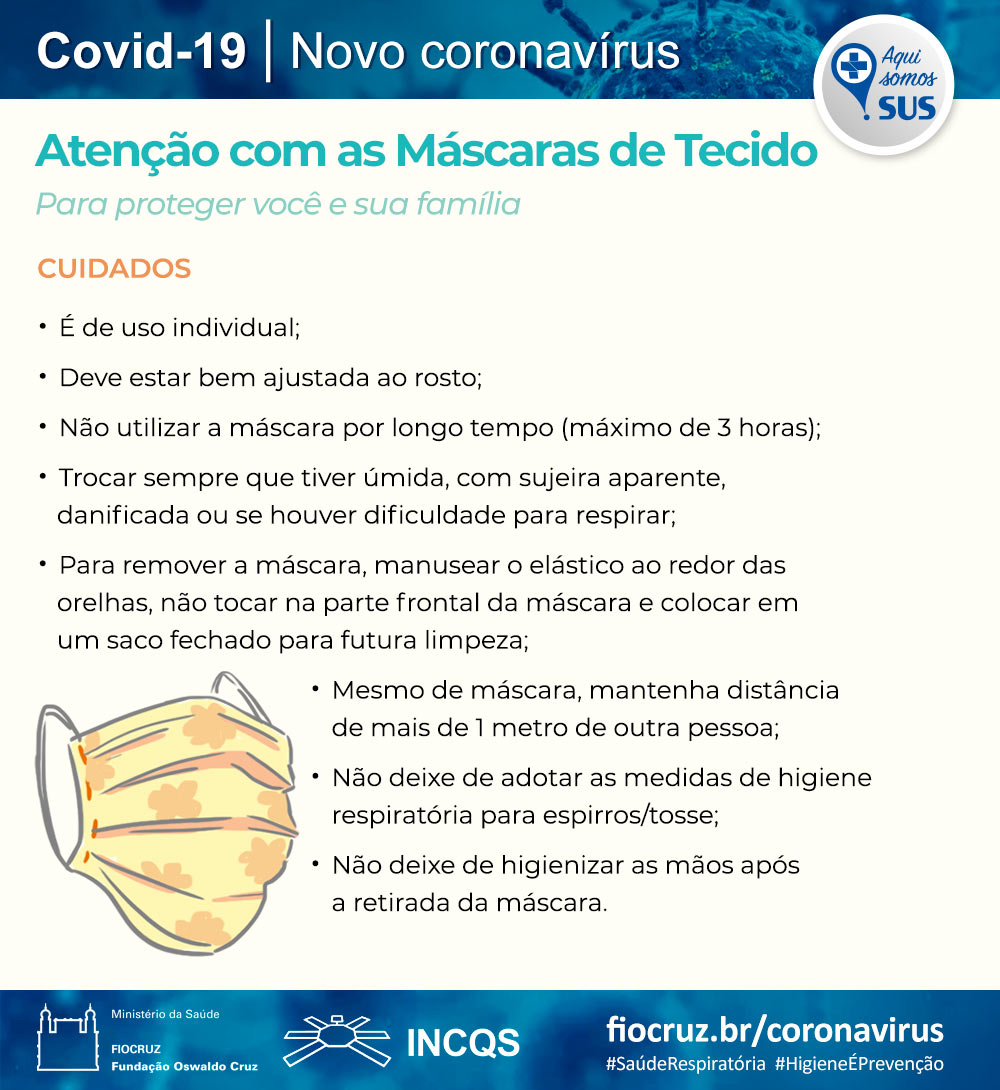

In [ ]:
# Display image
cv2_imshow(img)

##### Print predicted text

In [ ]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

text = pytesseract.image_to_string(img, lang='por')
printmd(text)

   

Covid-19 | Novo coronavirus aqu

HOMO

| sus
Atenção com as Máscaras de Tecido -

E a ( VC UC q

CUIDADOS

* É de uso individual;
* Deve estar bem ajustada ao rosto;
* Não utilizar a máscara por longo tempo (máximo de 3 horas);

* Trocar sempre que tiver úmida, com sujeira aparente,
danificada ou se houver dificuldade para respirar;

* Para remover a máscara, manusear o elástico ao redor das
orelhas, não tocar na parte frontal da máscara e colocar em
um saco fechado para futura limpeza;

* Mesmo de máscara, mantenha distância
de mais de 1 metro de outra pessoa;

  
 

>) * Não deixe de adotar as medidas de higiene
respiratória para espirros/tosse;

* Não deixe de higienizar as mãos após
a retirada da máscara.

Minis

o. E INCQS Efe Te gro geo go Ta NIIATES

 

[REAR VE or HSaúdeRespiratória &HigieneÉPrevenção


##### Preprocessing for Tesseract

To avoid all the ways your tesseract output accuracy can drop, you need to make sure the image is appropriately pre-processed.

This includes rescaling, binarization, noise removal, deskewing, etc.

To preprocess image for OCR, use any of the following python functions or follow the OpenCV documentation.

In [ ]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

In [ ]:
# get OpenCV image
img = cv2.imread(path_to_doc)

gray = get_grayscale(img)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)

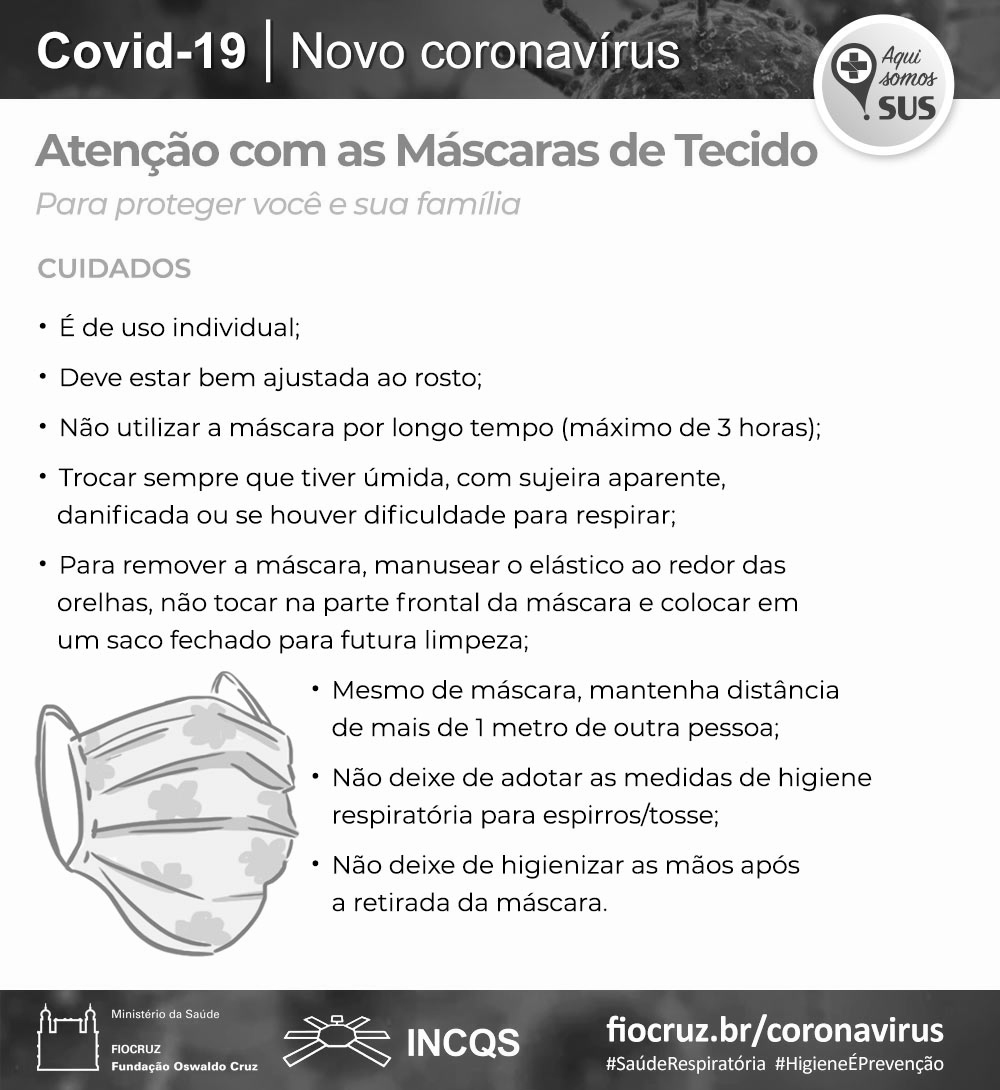

In [ ]:
cv2_imshow(gray)

In [ ]:
# Get text
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

text = pytesseract.image_to_string(gray, lang='por')
printmd(text)

   

Covid-19 | Novo coronavirus am,

[sus
Atenção com as Máscaras de Tecido

* É de uso individual;
* Deve estar bem ajustada ao rosto;
* Não utilizar a máscara por longo tempo (máximo de 3 horas);

* Trocar sempre que tiver úmida, com sujeira aparente,
danificada ou se houver dificuldade para respirar;

* Para remover a máscara, manusear o elástico ao redor das
orelhas, não tocar na parte frontal da máscara e colocar em
um saco fechado para futura limpeza;

5" SN
a Ss * Não deixe de adotar as medidas de higiene
aa Ens respiratória para espirros/tosse;

e 1 E Não deixe de higienizar as mãos após
7 a retirada da máscara.

DOE G EE

 
  

* Mesmo de máscara, mantenha distância
de mais de 1 metro de outra pessoa;

      
 

mocitl Zea INCQS Lift gTr A So go ENTAO

 

[E CEA HSaúdeRespiratória HHigieneÉPrevenção


##### Getting boxes around text

Using Pytesseract, you can get the bounding box information for your OCR results using the following code.

The script below will give you bounding box information for each character detected by tesseract during OCR.

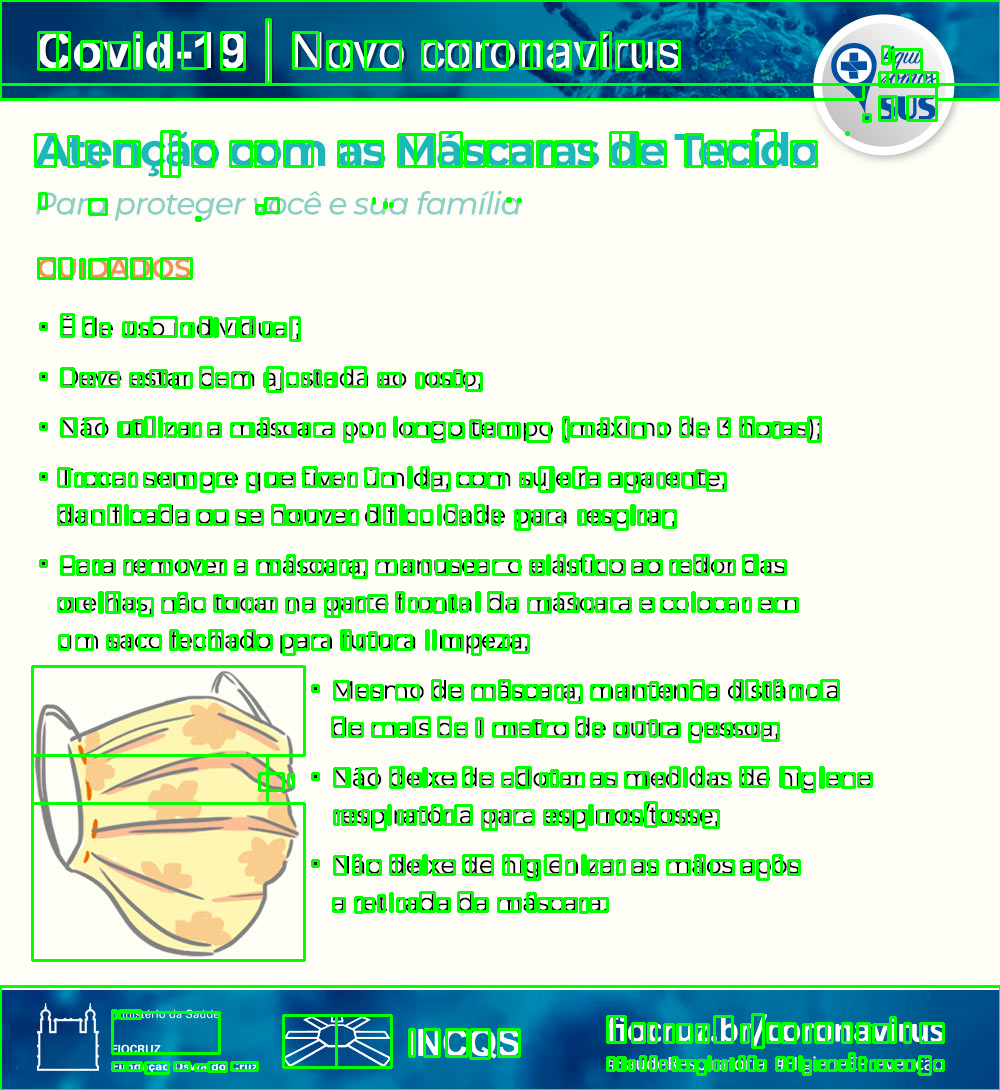

-1

In [ ]:
# get OpenCV image
img = cv2.imread(path_to_doc)

h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img) 
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

cv2_imshow(img)
cv2.waitKey(0)

In [ ]:
from pytesseract import Output

# get OpenCV image
img = cv2.imread(path_to_doc)

d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


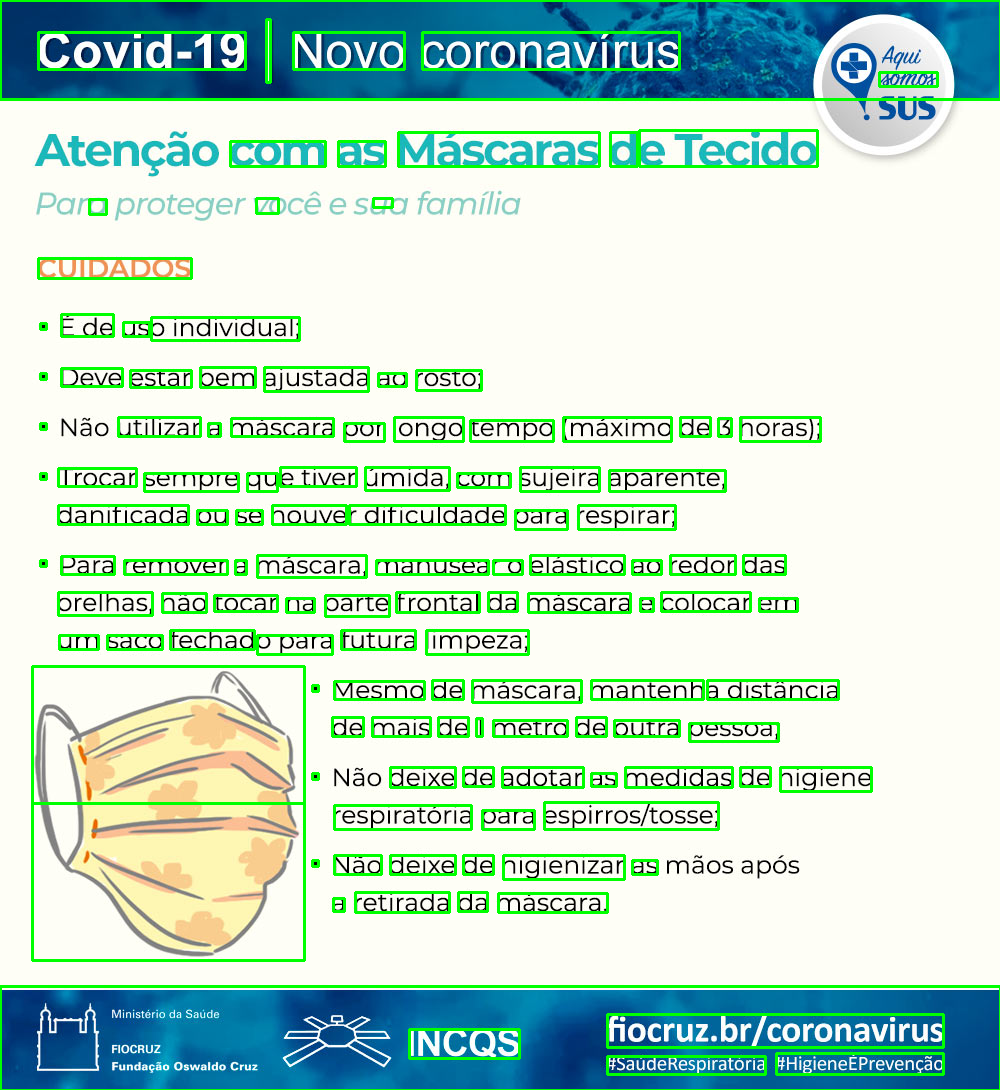

-1

In [ ]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2_imshow(img)
cv2.waitKey(0)

##### Search for a pattern

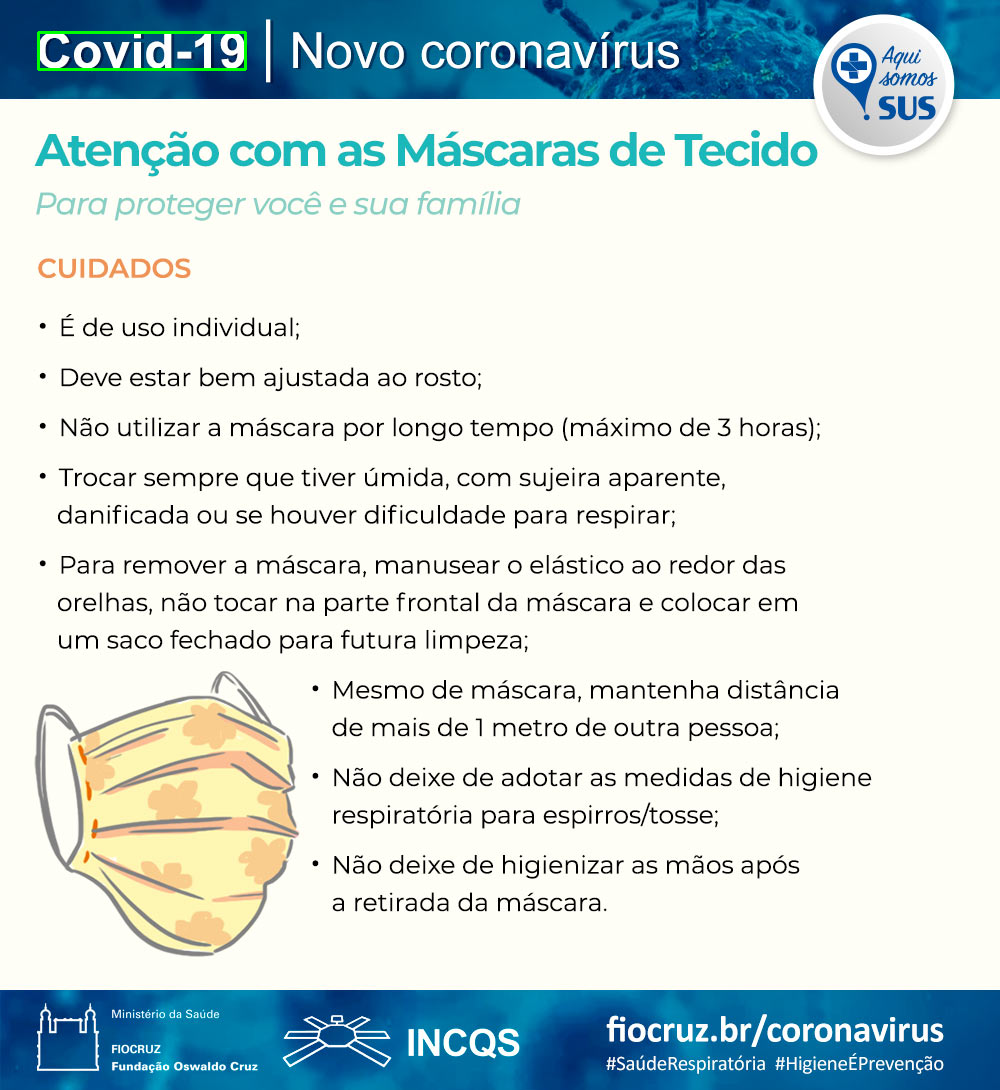

-1

In [ ]:
import re

# get OpenCV image
img = cv2.imread(path_to_doc)

d = pytesseract.image_to_data(img, output_type=Output.DICT)
keys = list(d.keys())

# date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'
pattern = '^(Covid-19)$'

n_boxes = len(d['text'])
for i in range(n_boxes):
  if int(d['conf'][i]) > 60:
    if re.match(pattern, d['text'][i]):
      (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
      img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
      
cv2_imshow(img)
cv2.waitKey(0)

#### 1. PDF

Let's analyze an one-page PDF about COVID-19 in Portuguese language (from a 85-page document: Boletim Epidemiológico Covid-19 - Nº 52 from the government of Brazil do 27/02/2021).

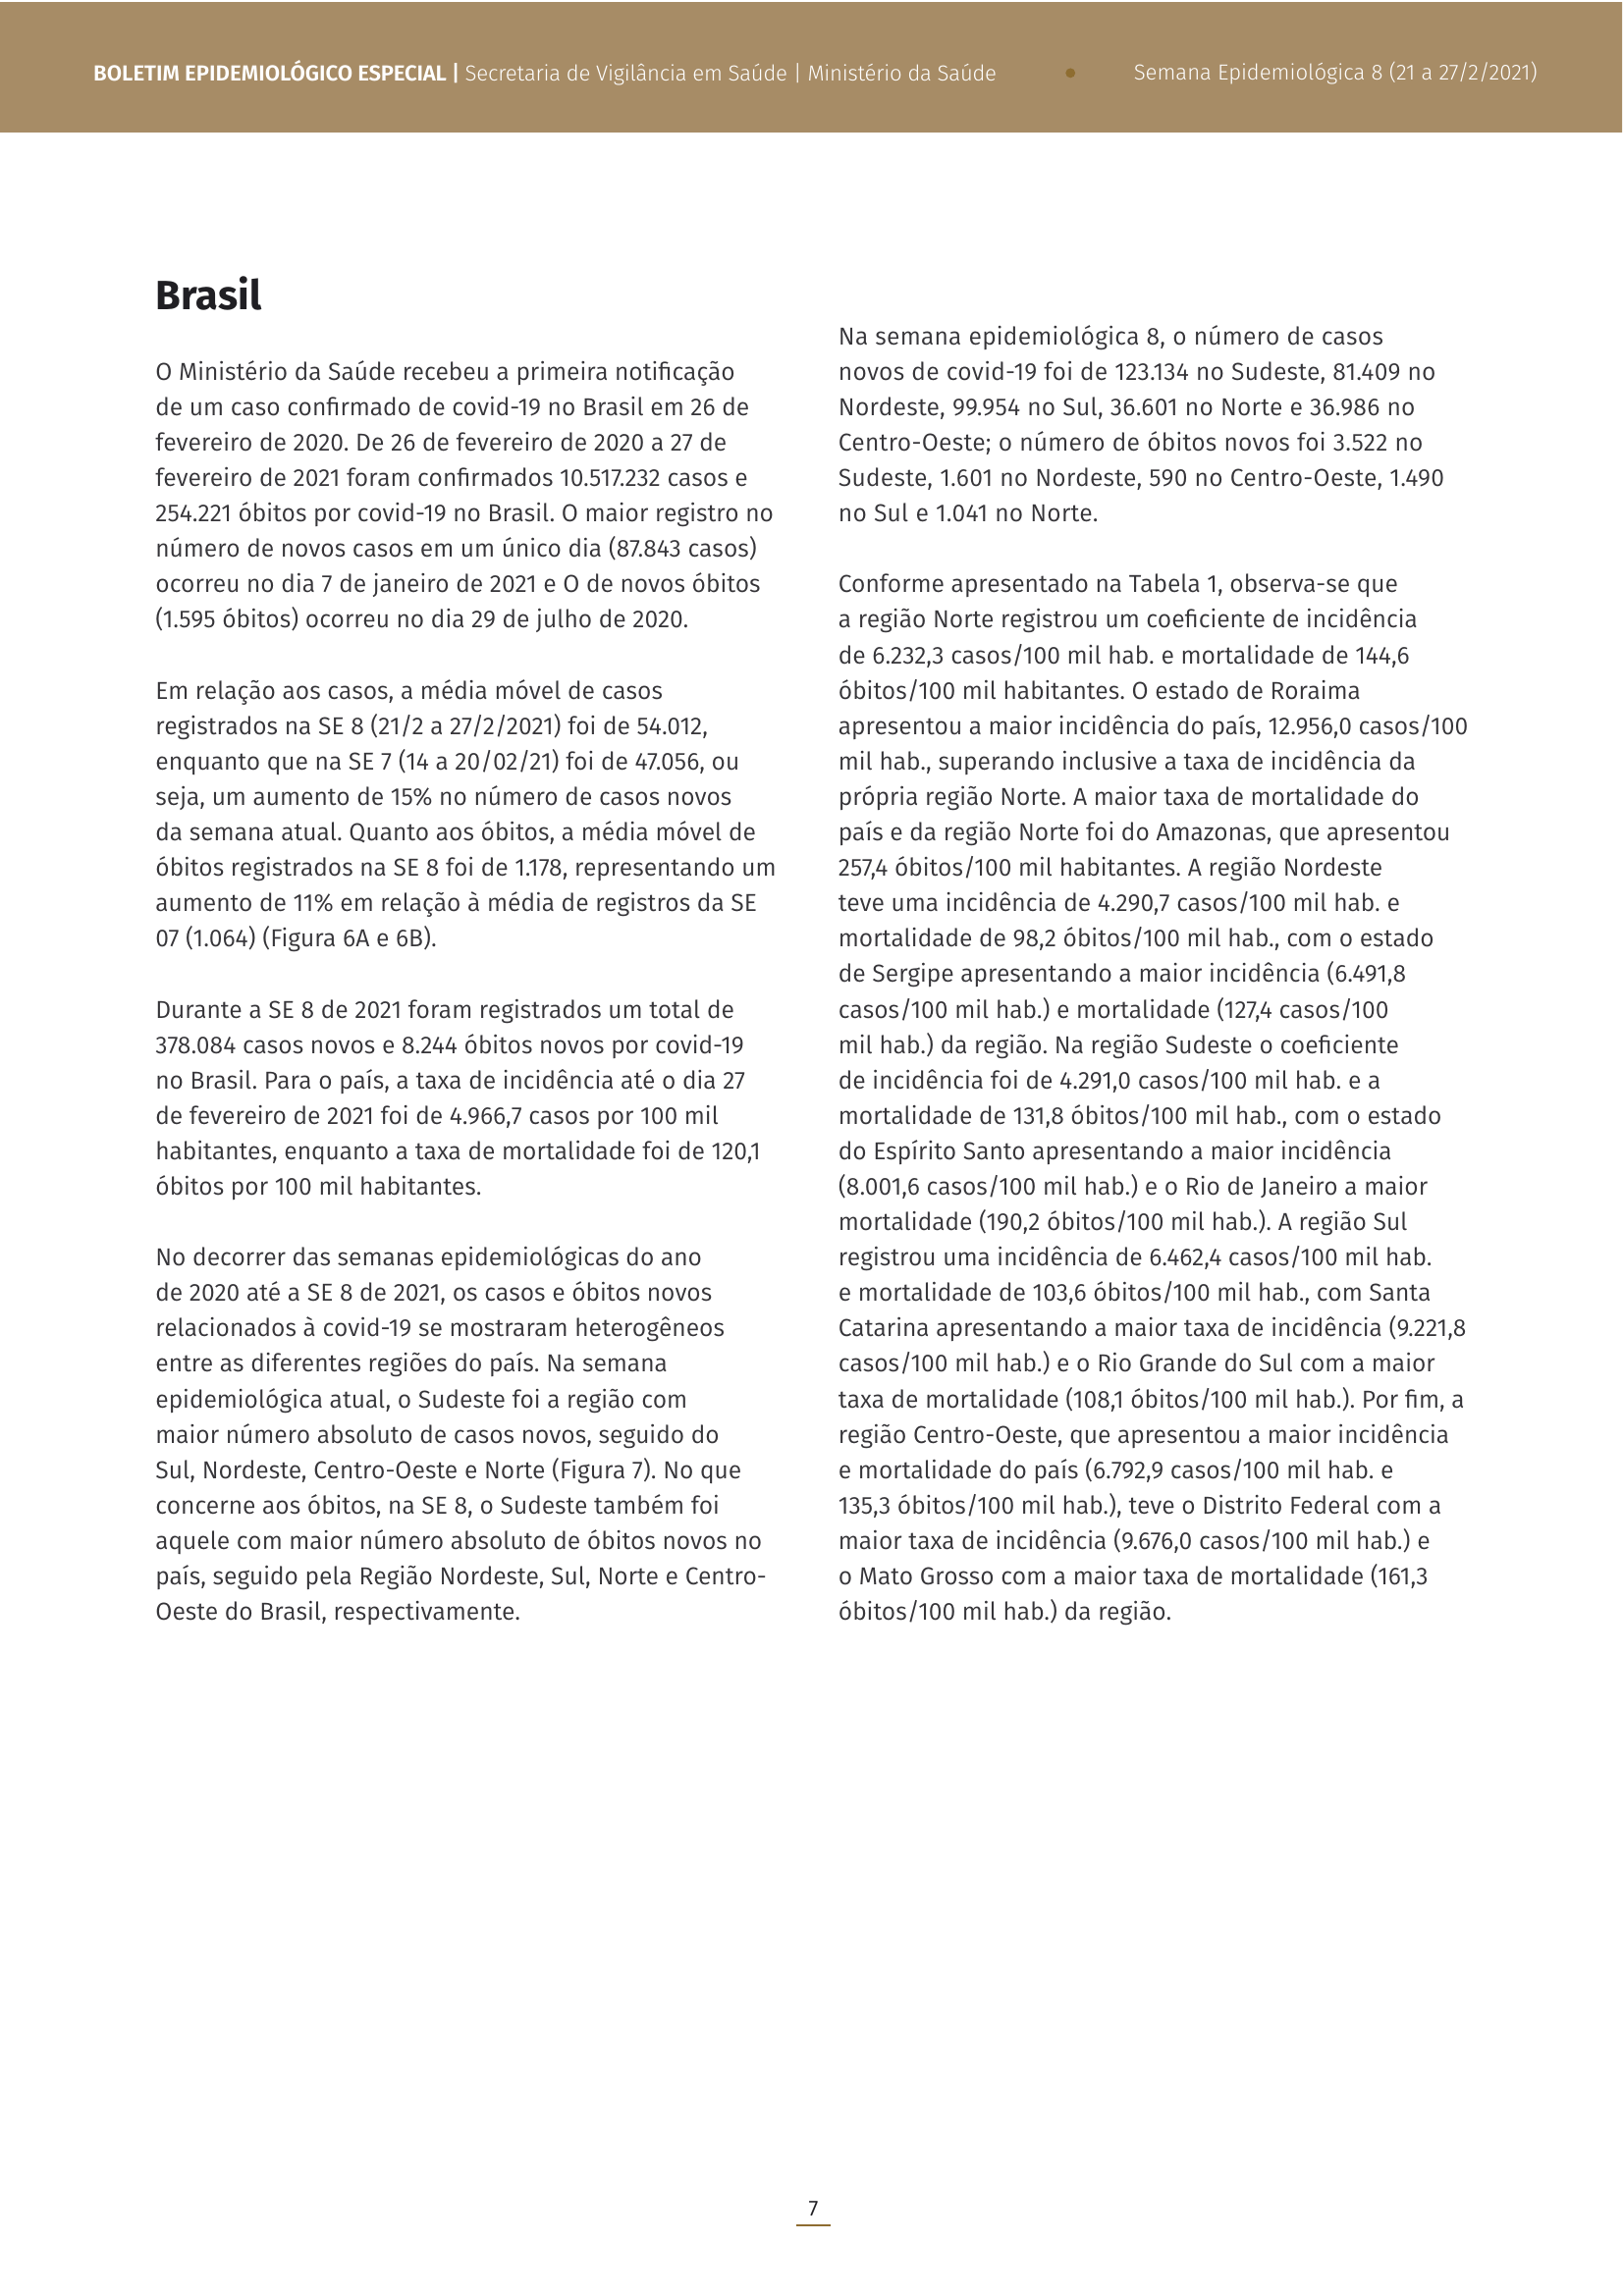

In [ ]:
import pdf2image
import numpy as np

from pdf2image.exceptions import (
PDFInfoNotInstalledError,
PDFPageCountError,
PDFSyntaxError
)

# Get the document
# source : https://www.gov.br/saude/pt-br/coronavirus/boletins-epidemiologicos/boletim-epidemiologico-covid-19-no-52.pdf/view
# We only keep the page about Brasil
path_to_data = "/content/drive/MyDrive/Colab Notebooks/PDF_with_DL/data/"
doc_name = "Brasil Boletim Epidemiológico Covid-19 - Nº 52.pdf"
path_to_doc = path_to_data + doc_name

# Get PIL images
imgs = pdf2image.convert_from_path(path_to_doc)

for i, img in enumerate(imgs):

  # save images
  fname = path_to_data + 'img' + str(i) + ".png"
  img.save(fname, "PNG")

  # get OpenCV image
  img = np.array(img)

  # show
  cv2_imshow(np.array(img))

##### Print predicted text

As we have only one page in our PDF, we can go on using the variable `img`.

In [ ]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

text = pytesseract.image_to_string(img, lang='por')
printmd(text)

BOLETIM EPIDEMIOLÓGICO ESPECIAL | Secretaria de Vigilância em Saúde | Ministério da Saúde

Brasil

O Ministério da Saúde recebeu a primeira notificação

de um caso confirmado de covid-19 no Brasil em 26 de
fevereiro de 2020. De 26 de fevereiro de 2020 a 27 de
fevereiro de 2021 foram confirmados 10.517.232 casos e
254.221 óbitos por covid-19 no Brasil. O maior registro no
número de novos casos em um único dia (87.843 casos)
ocorreu no dia 7 de janeiro de 2021 e O de novos óbitos
(1.595 óbitos) ocorreu no dia 29 de julho de 2020.

Em relação aos casos, a média móvel de casos
registrados na SE 8 (21/2 a 27/2/2021) foi de 54.012,
enquanto que na SE 7 (14 a 20/02/21) foi de 47.056, ou
seja, um aumento de 15% no número de casos novos

da semana atual. Quanto aos óbitos, a média móvel de
óbitos registrados na SE 8 foi de 1.178, representando um
aumento de 11% em relação à média de registros da SE
07 (1.064) (Figura 6A e 68).

Durante a SE 8 de 2021 foram registrados um total de
378.084 casos novos e 8.244 óbitos novos por covid-19
no Brasil. Para o país, a taxa de incidência até o dia 27
de fevereiro de 2021 foi de 4.966,7 casos por 100 mil
habitantes, enquanto a taxa de mortalidade foi de 12071
óbitos por 100 mil habitantes.

No decorrer das semanas epidemiológicas do ano

de 2020 até a SE 8 de 2021, os casos e óbitos novos
relacionados à covid-19 se mostraram heterogêneos
entre as diferentes regiões do país. Na semana
epidemiológica atual, o Sudeste foi a região com

maior número absoluto de casos novos, seguido do
Sul, Nordeste, Centro-Oeste e Norte (Figura 7). No que
concerne aos óbitos, na SE 8, o Sudeste também foi
aquele com maior número absoluto de óbitos novos no
país, seguido pela Região Nordeste, Sul, Norte e Centro-
Oeste do Brasil, respectivamente.

 

Na semana epidemiológica 8, o número de casos
novos de covid-19 foi de 123.134 no Sudeste, 81.409 no
Nordeste, 99.954 no Sul, 36.601 no Norte e 36.986 no
Centro-Oeste; o número de óbitos novos foi 3.522 no
Sudeste, 1.601 no Nordeste, 590 no Centro-Oeste, 1.490
no Sule 1.041 no Norte.

Conforme apresentado na Tabela 1, observa-se que

a região Norte registrou um coeficiente de incidência

de 6.232,3 casos/100 mil hab. e mortalidade de 144,6
óbitos/100 mil habitantes. O estado de Roraima
apresentou a maior incidência do país, 12.956,0 casos/100
mil hab., superando inclusive a taxa de incidência da
própria região Norte. A maior taxa de mortalidade do
país e da região Norte foi do Amazonas, que apresentou
257,4 óbitos/100 mil habitantes. A região Nordeste

teve uma incidência de 4.290,7 casos/100 mil hab. e
mortalidade de 98,2 óbitos/100 mil hab., com o estado
de Sergipe apresentando a maior incidência (6.491,8
casos/100 mil hab.) e mortalidade (127,4 casos/100

mil hab.) da região. Na região Sudeste o coeficiente

de incidência foi de 4.291,0 casos/100 mil hab. e a
mortalidade de 131,8 óbitos/100 mil hab., com o estado
do Espírito Santo apresentando a maior incidência
(8.001,6 casos /100 mil hab.) e o Rio de Janeiro a maior
mortalidade (190,2 óbitos/100 mil hab.). A região Sul
registrou uma incidência de 6.462,4 casos/100 mil hab.

e mortalidade de 103,6 óbitos/100 mil hab., com Santa
Catarina apresentando a maior taxa de incidência (9.221,8
casos/100 mil hab.) e o Rio Grande do Sul com a maior
taxa de mortalidade (10871 óbitos/100 mil hab.). Por fim, a
região Centro-Oeste, que apresentou a maior incidência
e mortalidade do país (6.792,9 casos/100 mil hab. e

135,3 óbitos/100 mil hab.), teve o Distrito Federal com a
maior taxa de incidência (9.676,0 casos/100 mil hab.) e

o Mato Grosso com a maior taxa de mortalidade (161,3
óbitos/100 mil hab.) da região.

Semana Epidemiológica 8 (21 a 27/2/2021)


##### Preprocessing for Tesseract

To avoid all the ways your tesseract output accuracy can drop, you need to make sure the image is appropriately pre-processed.

This includes rescaling, binarization, noise removal, deskewing, etc.

To preprocess image for OCR, use any of the following python functions or follow the OpenCV documentation.

In [ ]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

In [ ]:
# Get PIL images
imgs = pdf2image.convert_from_path(path_to_doc)
for i, img in enumerate(imgs):
  # get OpenCV image
  img = np.array(img)
  
gray = get_grayscale(img)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)

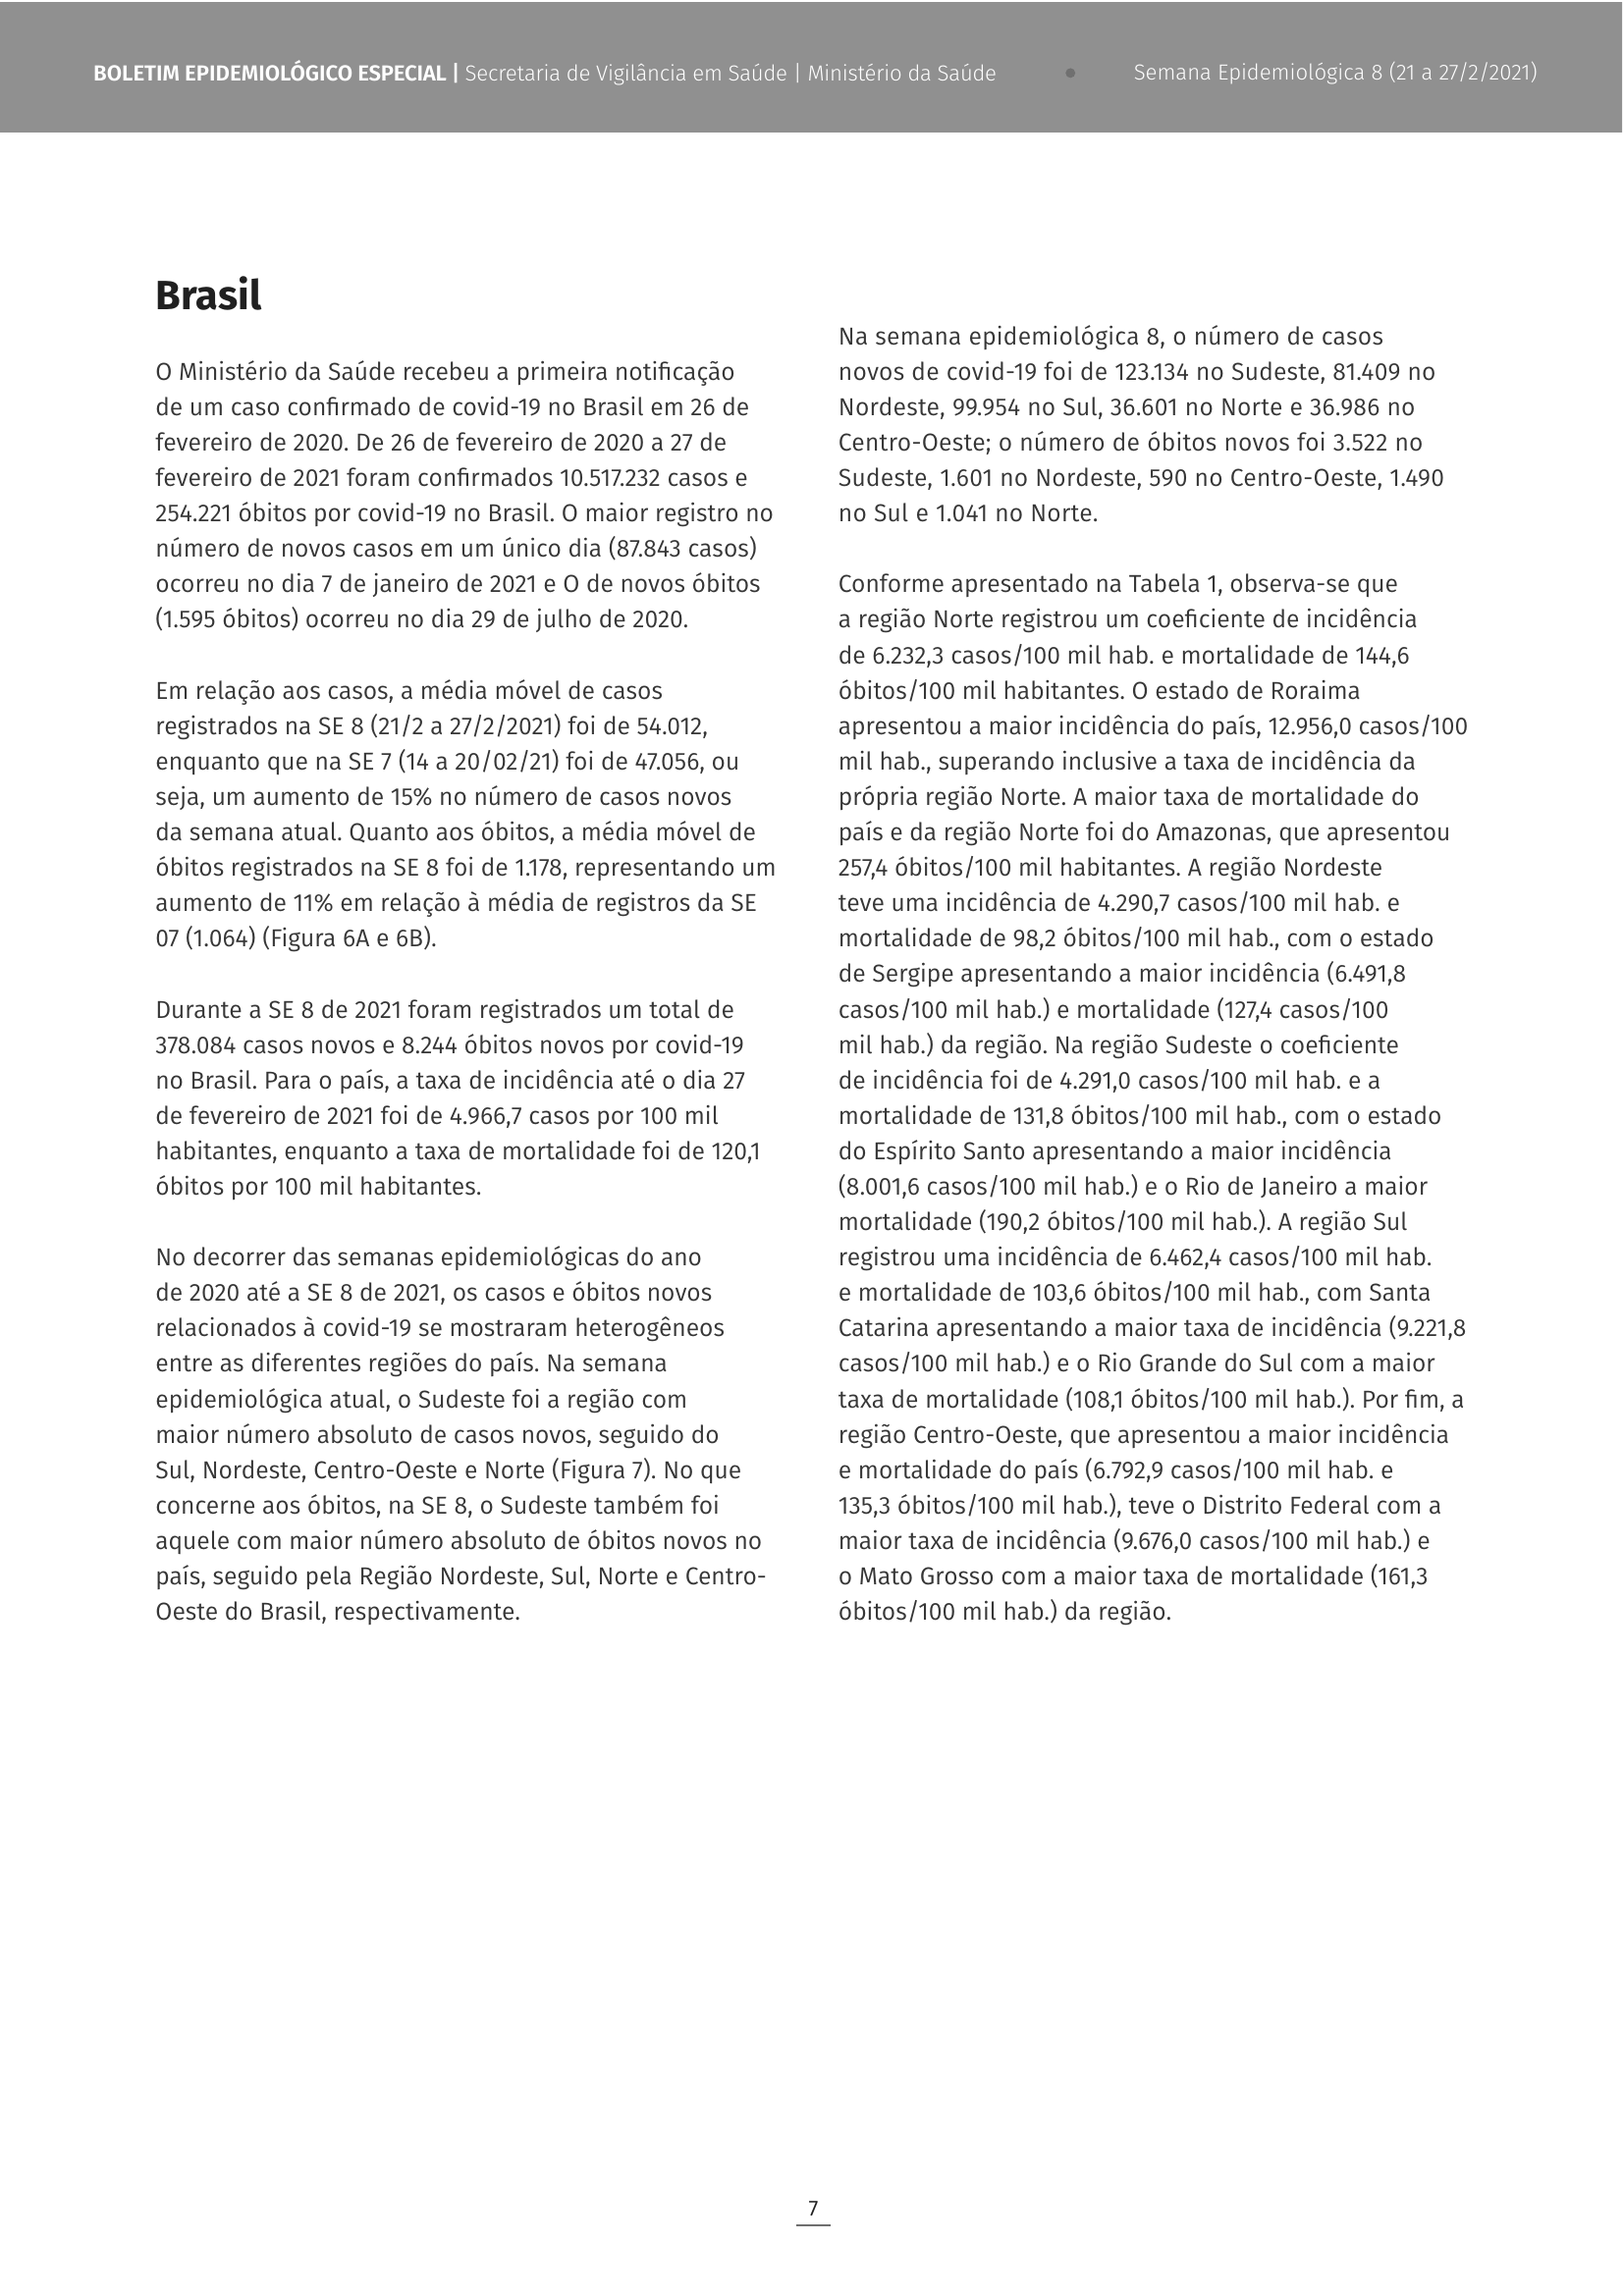

In [ ]:
cv2_imshow(gray)

In [ ]:
# Get text
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

text = pytesseract.image_to_string(img, lang='por')
printmd(text)

BOLETIM EPIDEMIOLÓGICO ESPECIAL | Secretaria de Vigilância em Saúde | Ministério da Saúde

Brasil

O Ministério da Saúde recebeu a primeira notificação

de um caso confirmado de covid-19 no Brasil em 26 de
fevereiro de 2020. De 26 de fevereiro de 2020 a 27 de
fevereiro de 2021 foram confirmados 10.517.232 casos e
254.221 óbitos por covid-19 no Brasil. O maior registro no
número de novos casos em um único dia (87.843 casos)
ocorreu no dia 7 de janeiro de 2021 e O de novos óbitos
(1.595 óbitos) ocorreu no dia 29 de julho de 2020.

Em relação aos casos, a média móvel de casos
registrados na SE 8 (21/2 a 27/2/2021) foi de 54.012,
enquanto que na SE 7 (14 a 20/02/21) foi de 47.056, ou
seja, um aumento de 15% no número de casos novos

da semana atual. Quanto aos óbitos, a média móvel de
óbitos registrados na SE 8 foi de 1.178, representando um
aumento de 11% em relação à média de registros da SE
07 (1.064) (Figura 6A e 68).

Durante a SE 8 de 2021 foram registrados um total de
378.084 casos novos e 8.244 óbitos novos por covid-19
no Brasil. Para o país, a taxa de incidência até o dia 27
de fevereiro de 2021 foi de 4.966,7 casos por 100 mil
habitantes, enquanto a taxa de mortalidade foi de 12071
óbitos por 100 mil habitantes.

No decorrer das semanas epidemiológicas do ano

de 2020 até a SE 8 de 2021, os casos e óbitos novos
relacionados à covid-19 se mostraram heterogêneos
entre as diferentes regiões do país. Na semana
epidemiológica atual, o Sudeste foi a região com

maior número absoluto de casos novos, seguido do
Sul, Nordeste, Centro-Oeste e Norte (Figura 7). No que
concerne aos óbitos, na SE 8, o Sudeste também foi
aquele com maior número absoluto de óbitos novos no
país, seguido pela Região Nordeste, Sul, Norte e Centro-
Oeste do Brasil, respectivamente.

 

Na semana epidemiológica 8, o número de casos
novos de covid-19 foi de 123.134 no Sudeste, 81.409 no
Nordeste, 99.954 no Sul, 36.601 no Norte e 36.986 no
Centro-Oeste; o número de óbitos novos foi 3.522 no
Sudeste, 1.601 no Nordeste, 590 no Centro-Oeste, 1.490
no Sule 1.041 no Norte.

Conforme apresentado na Tabela 1, observa-se que

a região Norte registrou um coeficiente de incidência

de 6.232,3 casos/100 mil hab. e mortalidade de 144,6
óbitos/100 mil habitantes. O estado de Roraima
apresentou a maior incidência do país, 12.956,0 casos/100
mil hab., superando inclusive a taxa de incidência da
própria região Norte. A maior taxa de mortalidade do
país e da região Norte foi do Amazonas, que apresentou
257,4 óbitos/100 mil habitantes. A região Nordeste

teve uma incidência de 4.290,7 casos/100 mil hab. e
mortalidade de 98,2 óbitos/100 mil hab., com o estado
de Sergipe apresentando a maior incidência (6.491,8
casos/100 mil hab.) e mortalidade (127,4 casos/100

mil hab.) da região. Na região Sudeste o coeficiente

de incidência foi de 4.291,0 casos/100 mil hab. e a
mortalidade de 131,8 óbitos/100 mil hab., com o estado
do Espírito Santo apresentando a maior incidência
(8.001,6 casos /100 mil hab.) e o Rio de Janeiro a maior
mortalidade (190,2 óbitos/100 mil hab.). A região Sul
registrou uma incidência de 6.462,4 casos/100 mil hab.

e mortalidade de 103,6 óbitos/100 mil hab., com Santa
Catarina apresentando a maior taxa de incidência (9.221,8
casos/100 mil hab.) e o Rio Grande do Sul com a maior
taxa de mortalidade (10871 óbitos/100 mil hab.). Por fim, a
região Centro-Oeste, que apresentou a maior incidência
e mortalidade do país (6.792,9 casos/100 mil hab. e

135,3 óbitos/100 mil hab.), teve o Distrito Federal com a
maior taxa de incidência (9.676,0 casos/100 mil hab.) e

o Mato Grosso com a maior taxa de mortalidade (161,3
óbitos/100 mil hab.) da região.

Semana Epidemiológica 8 (21 a 27/2/2021)


##### Getting boxes around text

Using Pytesseract, you can get the bounding box information for your OCR results using the following code.

The script below will give you bounding box information for each character detected by tesseract during OCR.

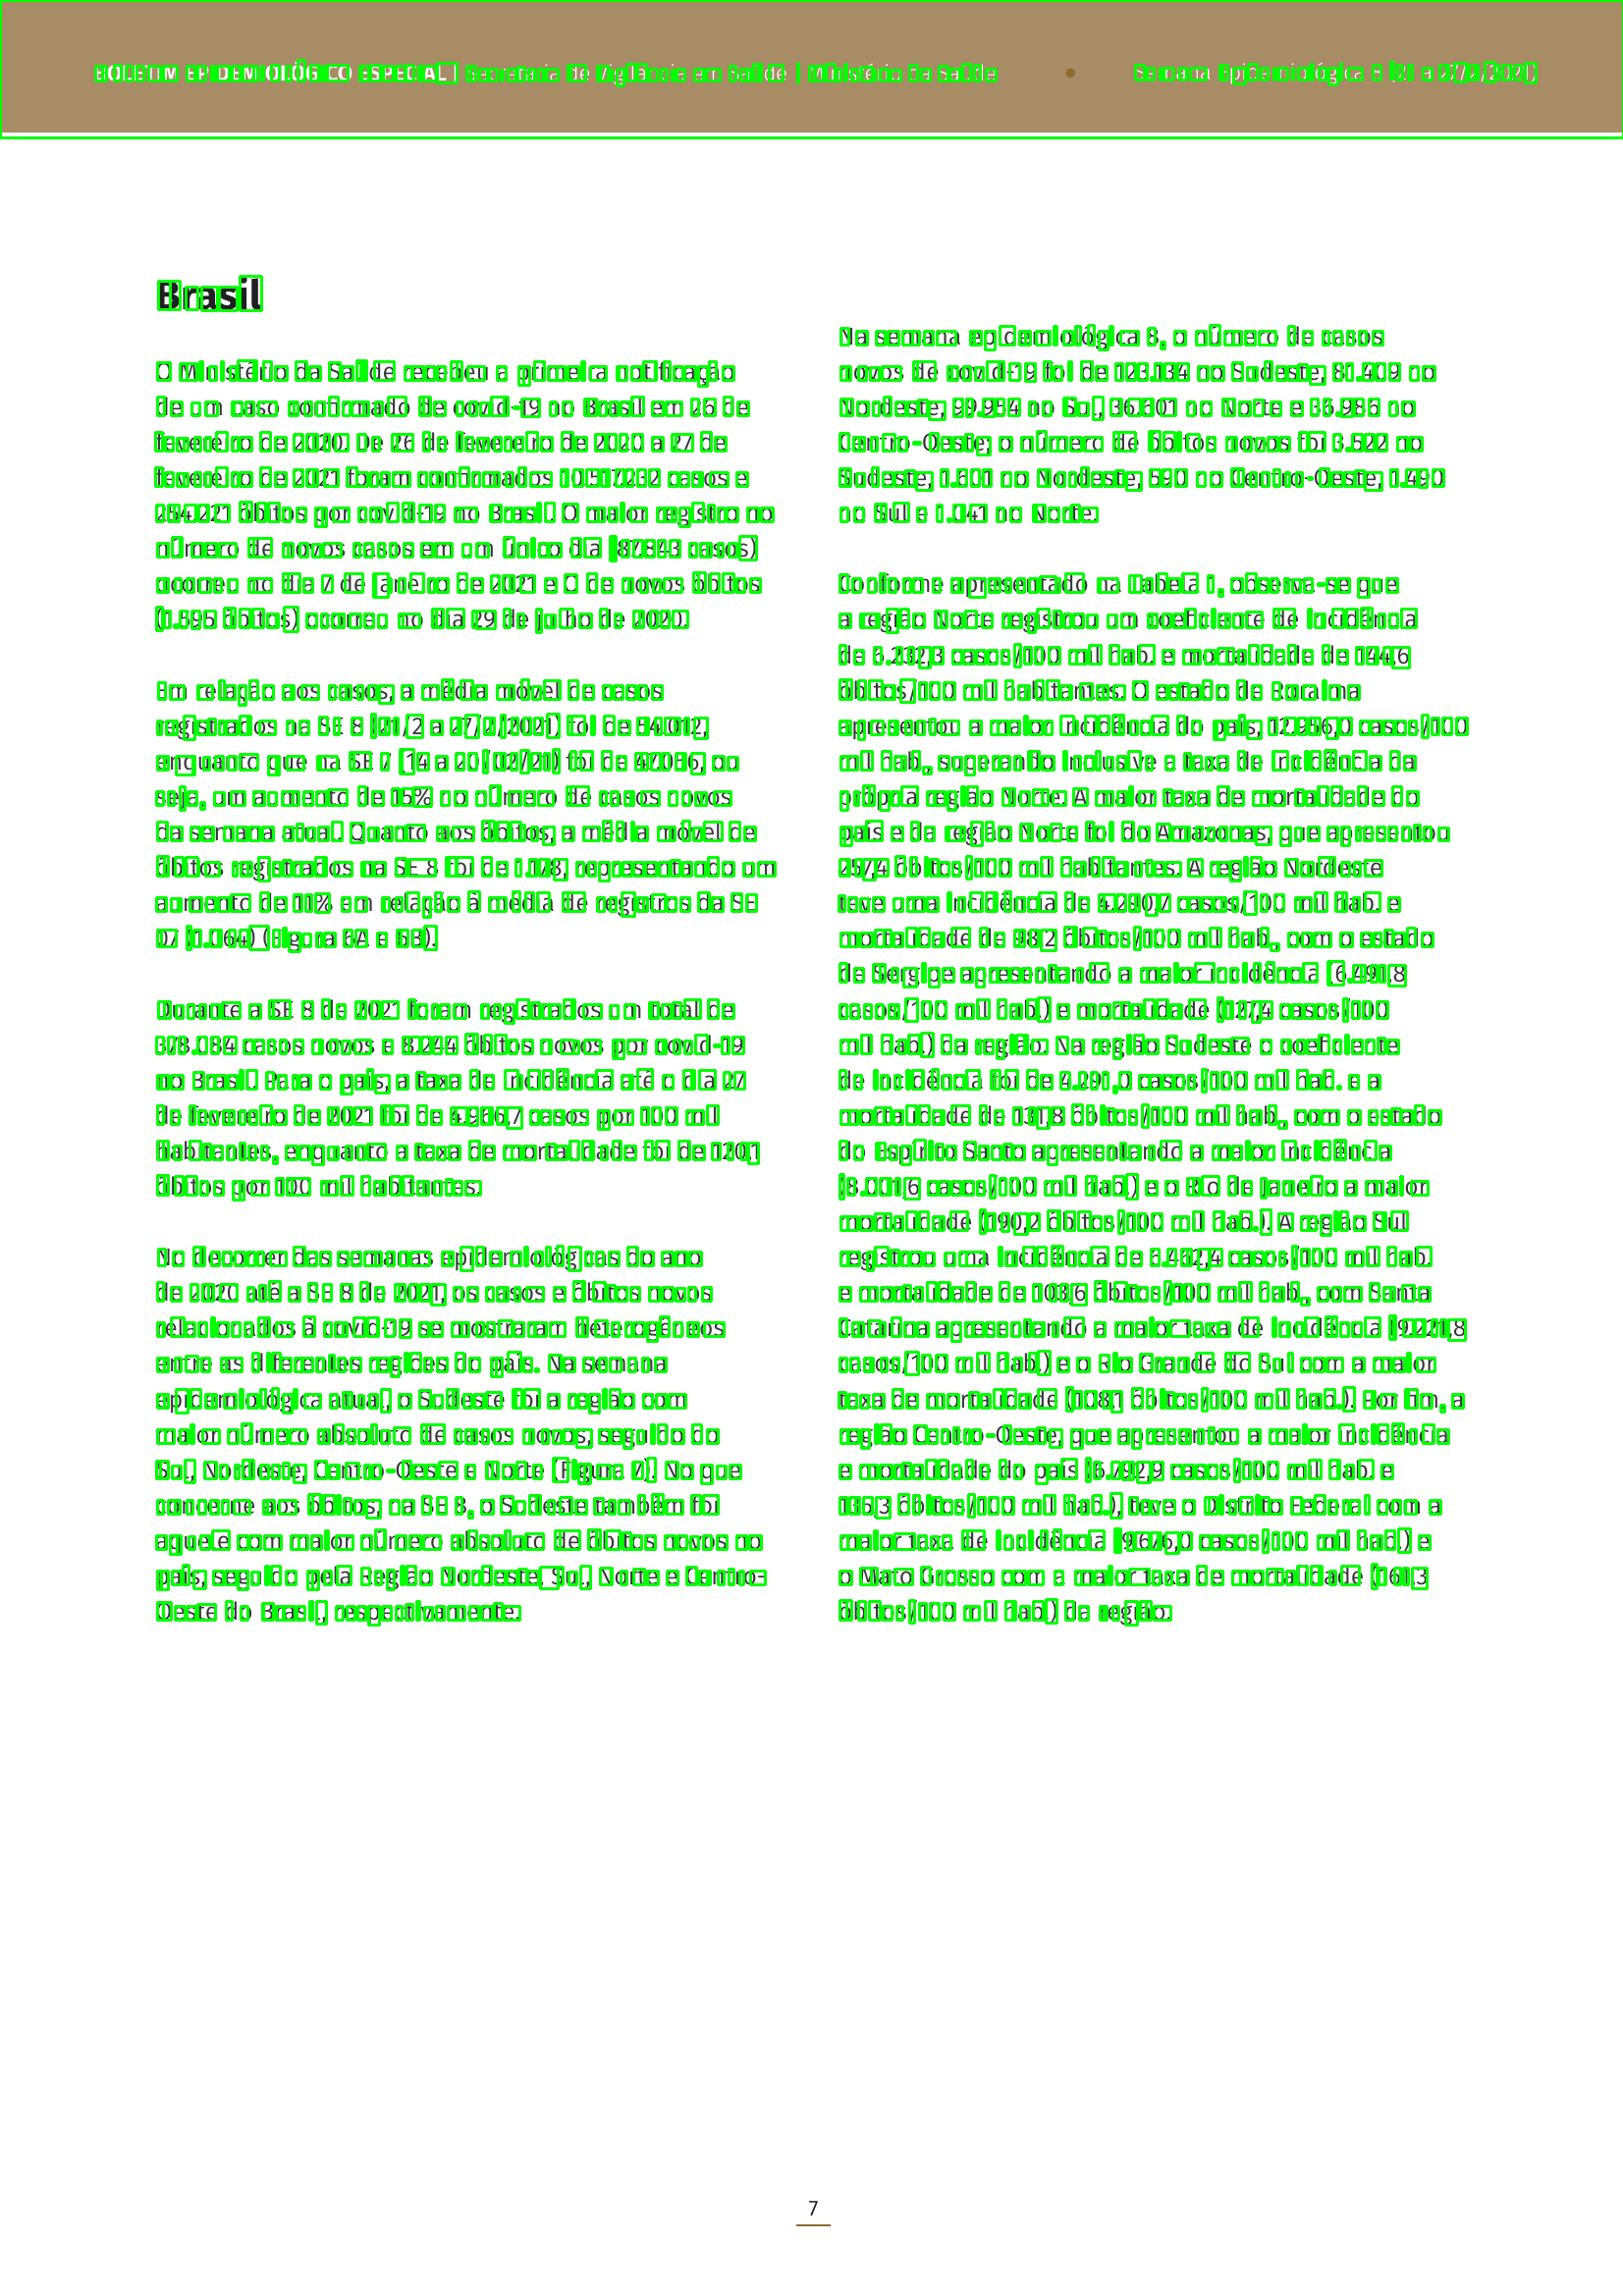

-1

In [ ]:
# Get PIL images
imgs = pdf2image.convert_from_path(path_to_doc)
for i, img in enumerate(imgs):
  # get OpenCV image
  img = np.array(img)
  
h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img) 
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

cv2_imshow(img)
cv2.waitKey(0)

In [ ]:
from pytesseract import Output

# Get PIL images
imgs = pdf2image.convert_from_path(path_to_doc)
for i, img in enumerate(imgs):
  # get OpenCV image
  img = np.array(img)

d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


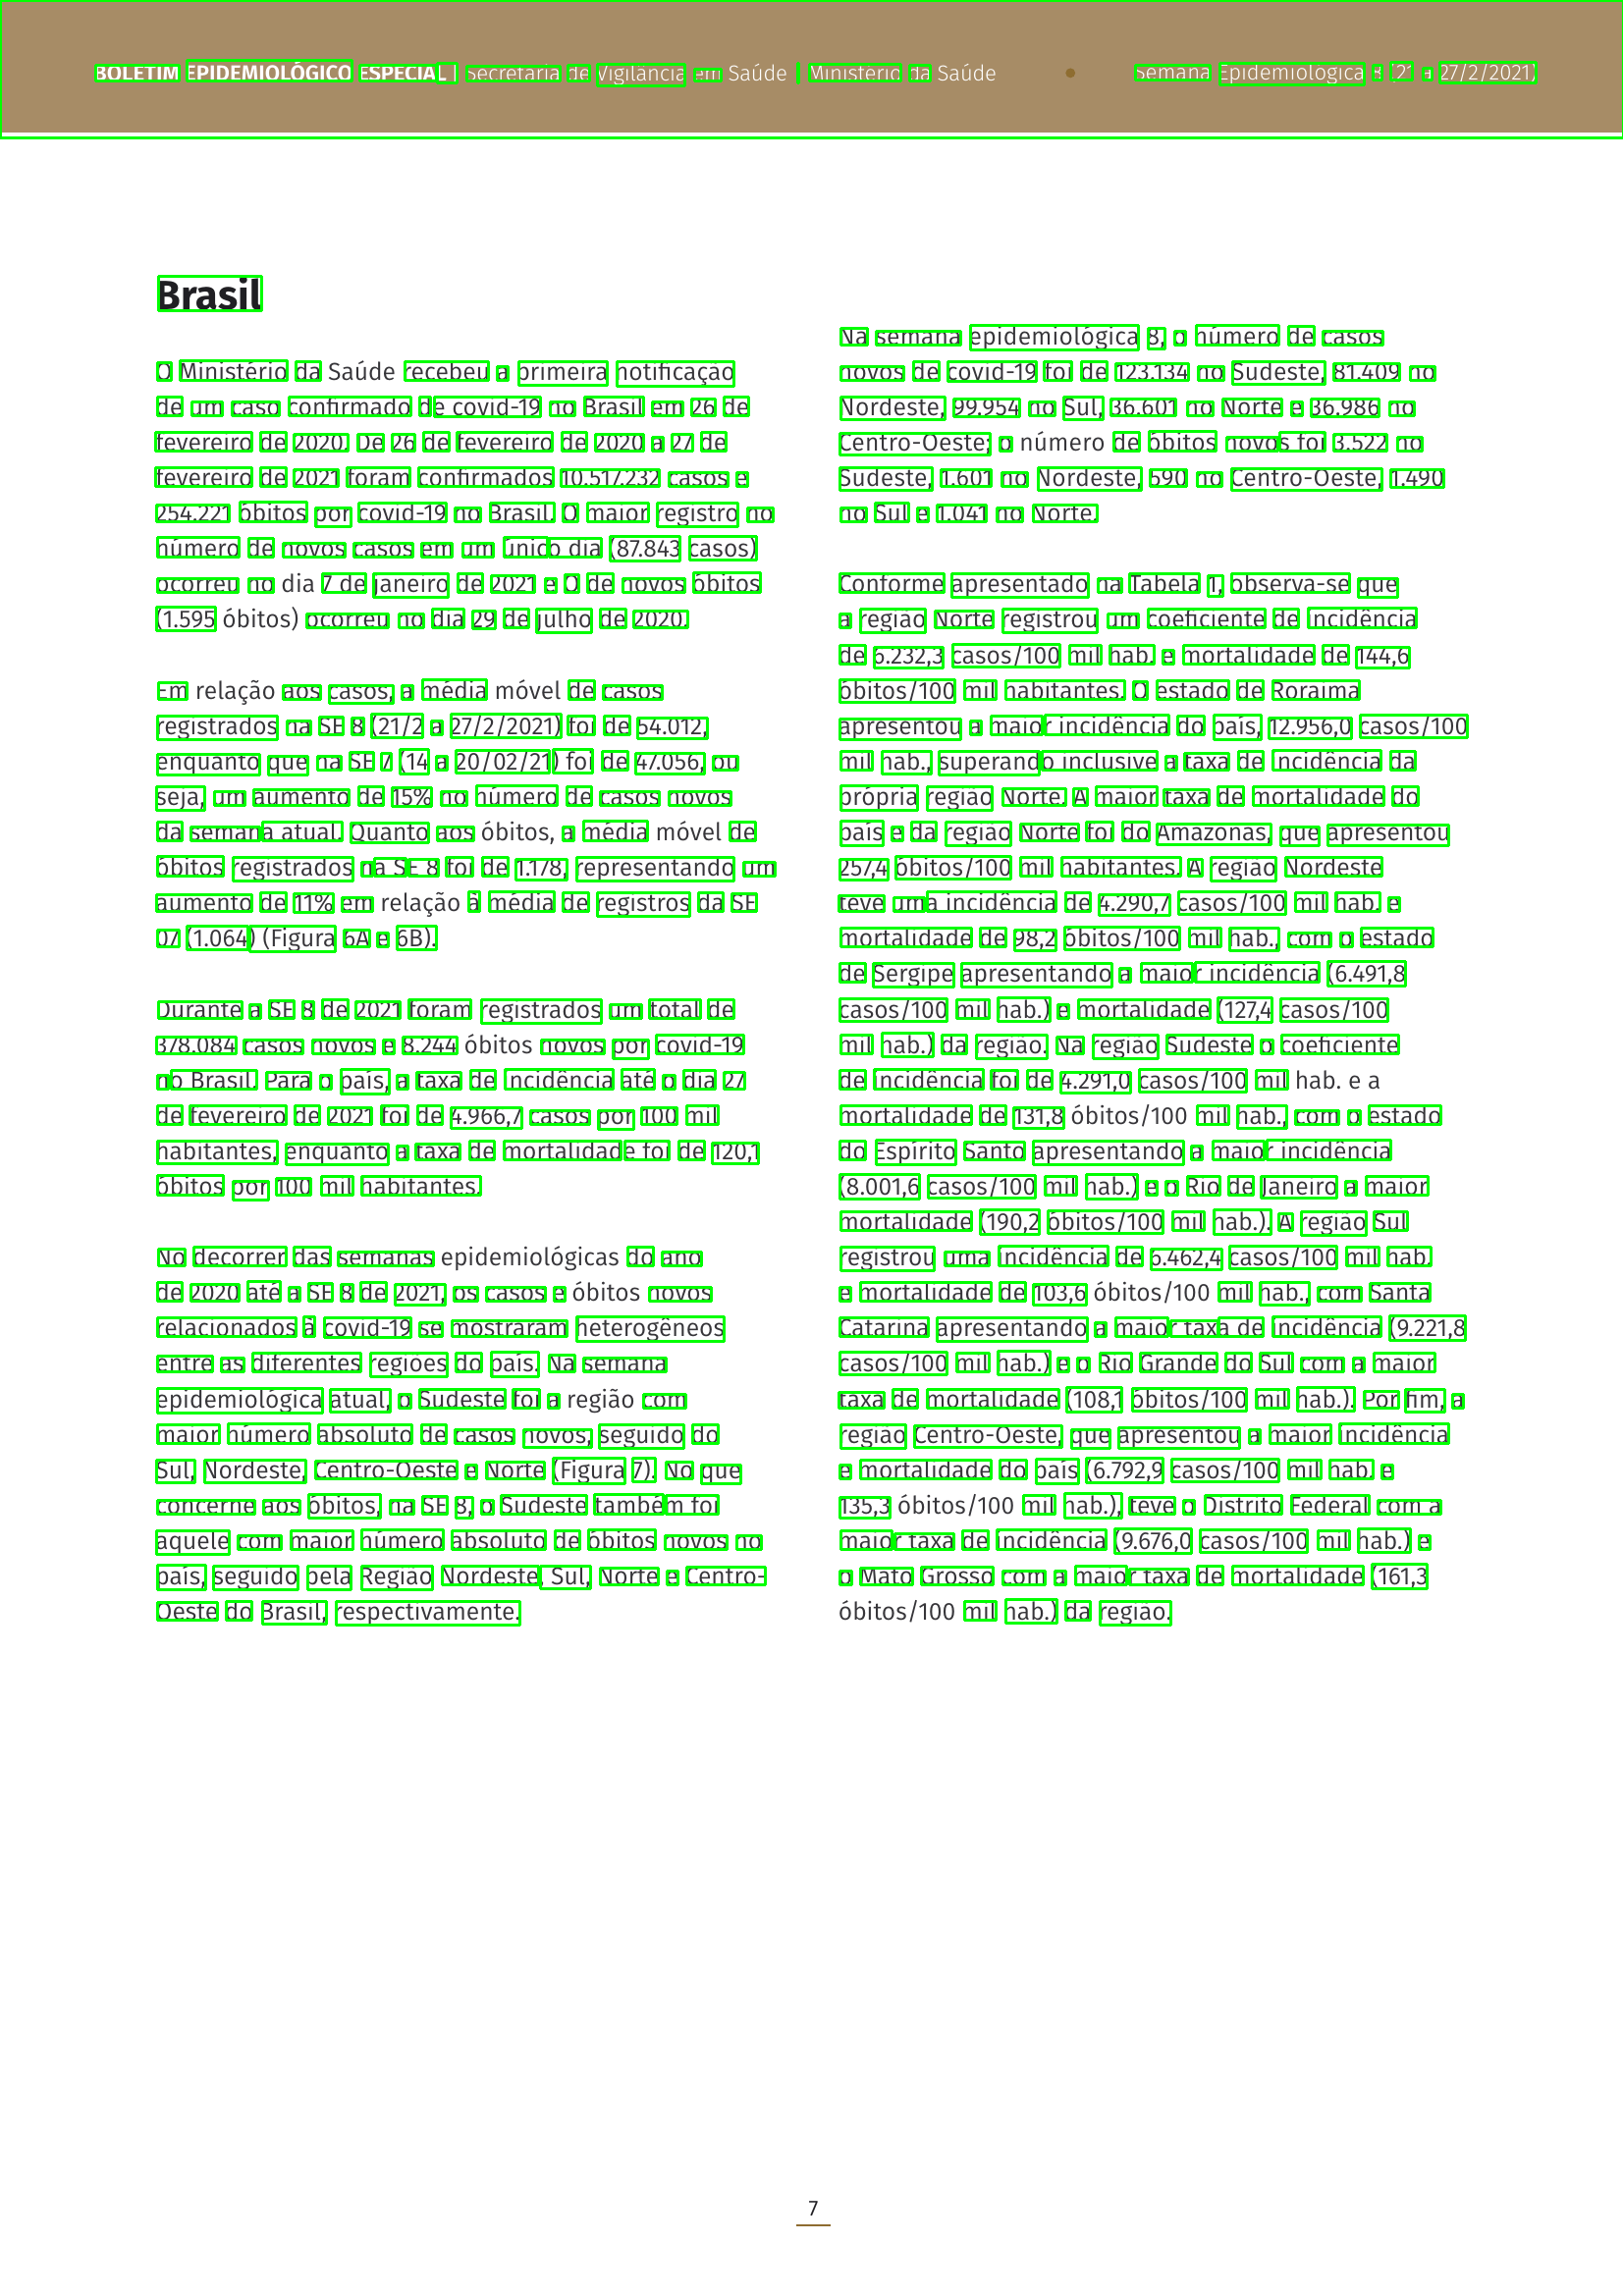

-1

In [ ]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2_imshow(img)
cv2.waitKey(0)

##### Search for a pattern

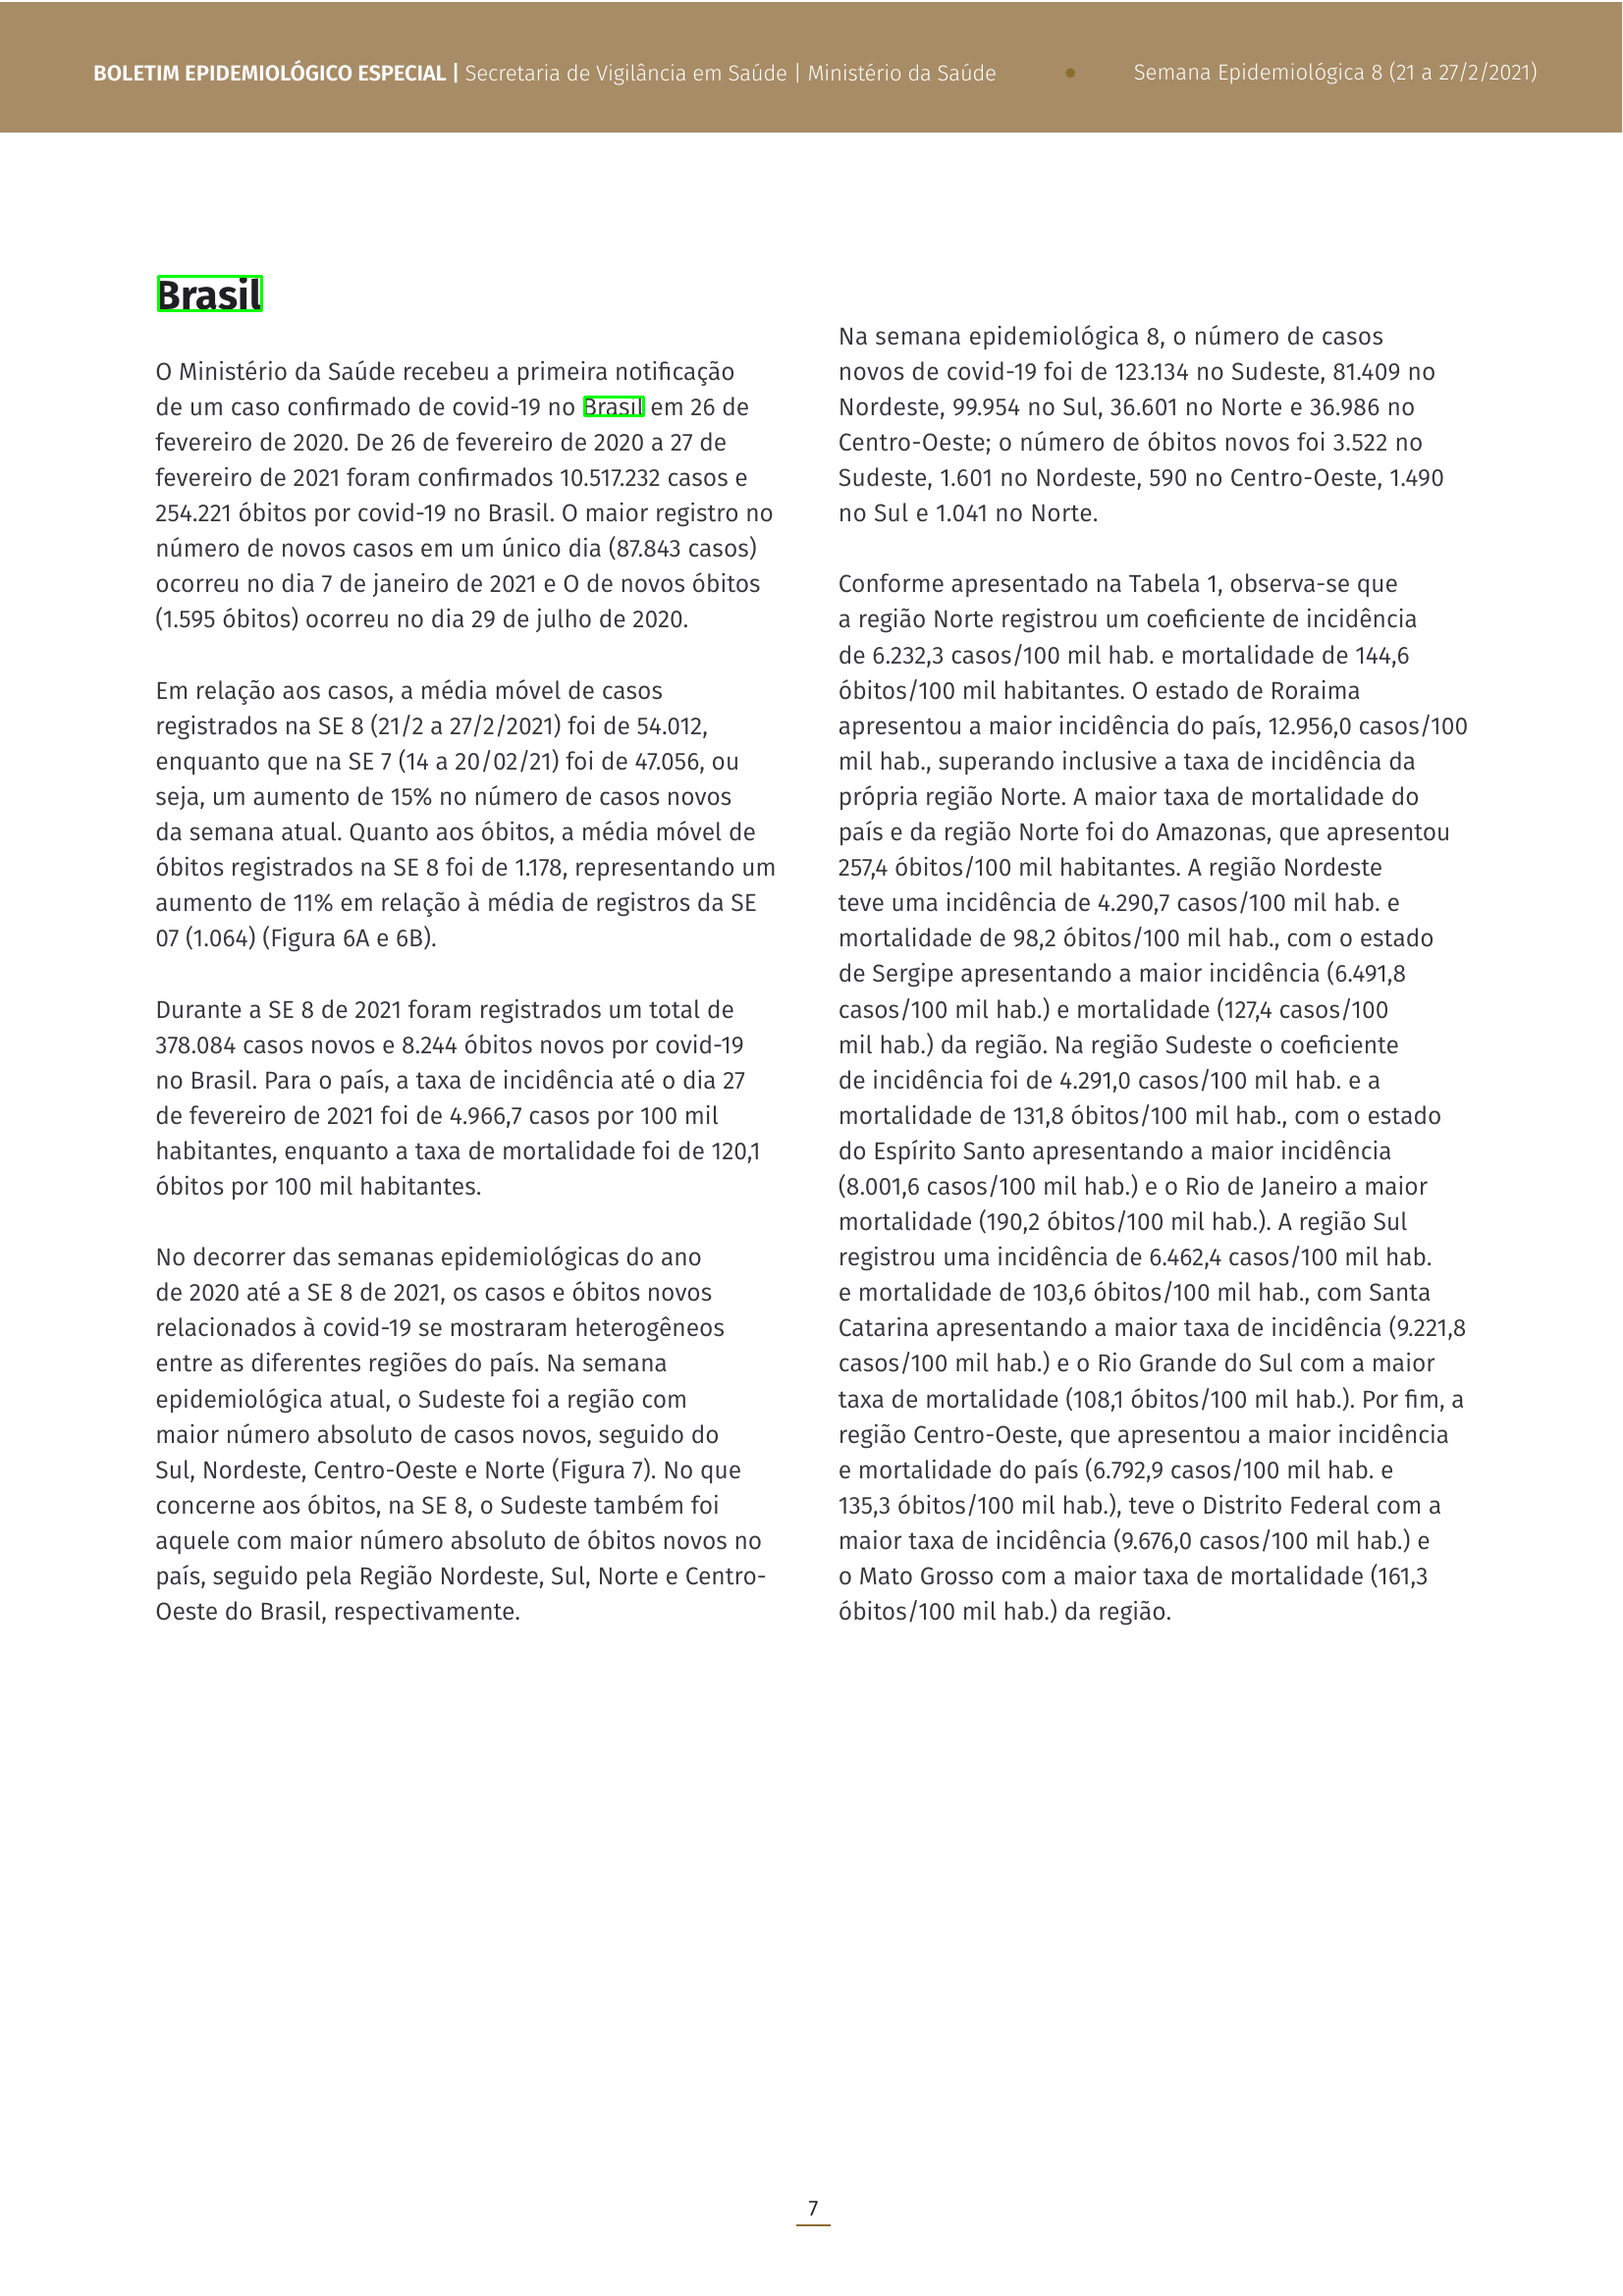

-1

In [ ]:
import re

# Get PIL images
imgs = pdf2image.convert_from_path(path_to_doc)
for i, img in enumerate(imgs):
  # get OpenCV image
  img = np.array(img)

d = pytesseract.image_to_data(img, output_type=Output.DICT)
keys = list(d.keys())

# date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'
pattern = '^(Brasil)$'

n_boxes = len(d['text'])
for i in range(n_boxes):
  if int(d['conf'][i]) > 60:
    if re.match(pattern, d['text'][i]):
      (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
      img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
      
cv2_imshow(img)
cv2.waitKey(0)

### Training Tesseract on custom data

Tesseract 4.00 includes a new neural network-based recognition engine that delivers significantly higher accuracy on document images. Neural networks require significantly more training data and train a lot slower than base Tesseract. For Latin-based languages, the existing model data provided has been trained on about 400000 text lines spanning about 4500 fonts.

In order to successfully run the Tesseract 4.0 LSTM training tutorial, you need to have a working installation of Tesseract 4 and Tesseract 4 Training Tools and also have the training scripts and required trained data files in certain directories. Visit github repo for files and tools.

A guide on how to train on your custom data and create `.traineddata` files can be found [here](https://www.endpoint.com/blog/2018/07/training-tesseract-models-from-scratch/), [here](https://pretius.com/how-to-prepare-training-files-for-tesseract-ocr-and-improve-characters-recognition/) and [here](https://medium.com/@vovaprivalov/tesseract-ocr-tips-custom-dictionary-to-improve-ocr-d2b9cd17850b).

## DocTR

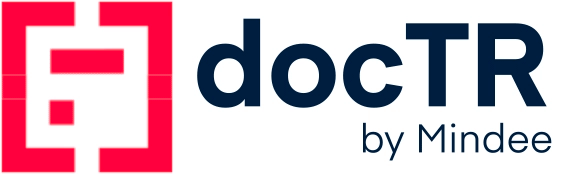

[DocTR](https://github.com/mindee/doctr): Optical Character Recognition with Deep Learning made seamless & accessible to anyone, powered by TensorFlow 2 (PyTorch in beta).

### Configuration

In [2]:
%%capture
!git clone https://github.com/mindee/doctr.git
!pip install -e doctr/.

Before continuing to run the cells of this notebook, **restart its runtime**.

**Note**: se usa o Colab em português, clique no menu "*Ambiente de execução*" > "*Reiniciar ambiente de execução*"

In [1]:
%%capture
!pip3 install tensorflow-addons

### Analysis of a document

In [2]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

model = ocr_predictor(det_arch='db_resnet50', reco_arch='crnn_vgg16_bn', pretrained=True)

  0%|          | 0/94178964 [00:00<?, ?it/s]

  0%|          | 0/58758994 [00:00<?, ?it/s]

In order to get words by line and not all words in just one line, we set to True the following attributes.

In [5]:
# Get the word boxes by lines
# source: https://github.com/mindee/doctr/discussions/511#discussioncomment-1450137
model.doc_builder.resolve_lines = True
model.doc_builder.resolve_blocks = True

#### 1. Image

In [10]:
# Get the document
# source: https://portal.fiocruz.br/coronavirus/material-para-download
path_to_data = "/content/drive/MyDrive/Colab Notebooks/PDF_with_DL/data/"
doc_name = "atencao_com_as_mascaras_de_tecido_2_0_0.jpg"
path_to_doc = path_to_data + doc_name

doc = DocumentFile.from_images(path_to_doc)

In [12]:
# Analyze
result = model(doc)

##### Show analysed document

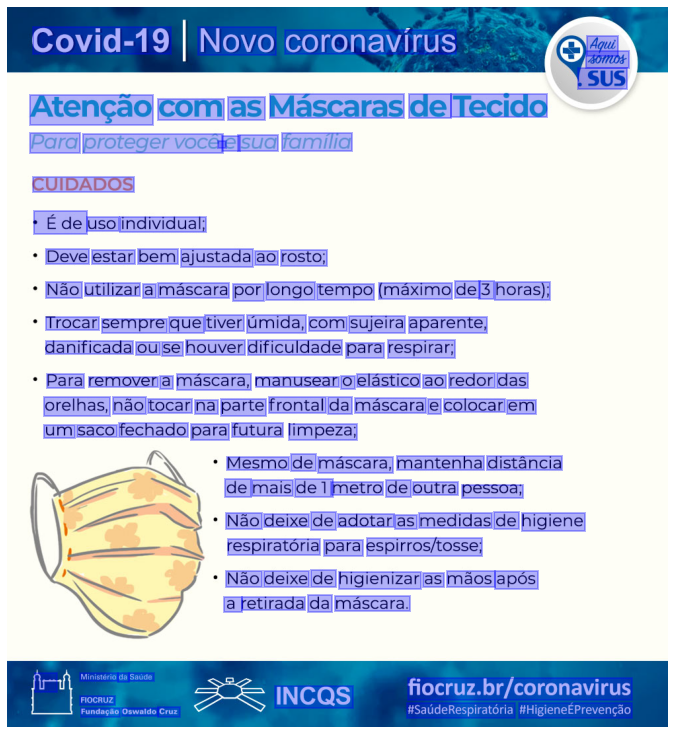

In [13]:
result.show(doc)

##### Print predicted text

In [14]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd(result.render())

Covid-19

Novo

coronavirus

Aqui
somos
SUS

Mascaras
familia

com

Tecido

as
I
e
sua

de

Atençao
Para

protegervoce

CUIDADOS
individual;
Éde
Deve
bem
ao
ajustada
rosto;
Nao
mascara
a
(maximo
longo
por
Trocar
tiver
sempre
que
umida,
aparente,
sujeira
danificada
ou
houver
se
dificuldade
para
respirar;
remover
Para
manusear
a
elastico
mascara,
O
tocar
nâo
na
frontal
orelhas,
mascara
da
parte
saco
um
fechado
futura
para
limpeza;
Mesmo
de
mascara,
mais
metro
de
del
deixe
adotar
Nao
de
respiratoria
para
Nao
deixe
de
retirada
a
da

uso
estar
utilizar

tempo
com

de
3
horas);

ao
redor
colocar
e

das
em

mantenha
outra
de
medidas
as
espirros/tosse;

distância
pessoa,
de
higiene

maos
as

higienizar
mascara.

apos

Ministério
Saude
da
FIOCRUZ
Oswaldo
Fundaçao
Cruz

ir

fiocruz.br/coronavirus

INCQS

HSaudeRespiratoria

HHigienetPrevengdo

**Note**: without the attribute change to True done before teh document scanning, the result would have been as following:
````
Covid-19 Novo coronavirus Aqui somos SUS Mascaras com Tecido as de Atençao I Para familia e sua protegervoce CUIDADOS uso individual; Éde estar Deve bem ao
ajustada rosto; utilizar Nao mascara a tempo (maximo longo de por 3 horas); Trocar tiver sempre com que umida, aparente, sujeira danificada ou houver se dificuldade
para respirar; remover Para manusear a elastico mascara, O ao das redor tocar nâo na frontal orelhas, mascara colocar da parte e em saco um fechado futura para
limpeza; Mesmo de mantenha distância mascara, mais metro de outra del de pessoa, deixe adotar Nao medidas de as de higiene respiratoria espirros/tosse; para Nao
deixe de maos as higienizar apos retirada a mascara. da Ministério Saude da ir fiocruz.br/coronavirus FIOCRUZ INCQS Oswaldo Fundaçao Cruz HSaudeRespiratoria HHigienetPrevengdo
````

##### Get predicted words with coordinates and scores

In [15]:
json_output = result.export()
dict(list(json_output.items())[0:2])

{'pages': [{'blocks': [{'artefacts': [],
     'geometry': ((0.0380859375, 0.02734375), (0.248046875, 0.0654296875)),
     'lines': [{'geometry': ((0.0380859375, 0.02734375),
        (0.248046875, 0.0654296875)),
       'words': [{'confidence': 0.9314253926277161,
         'geometry': ((0.0380859375, 0.02734375), (0.248046875, 0.0654296875)),
         'value': 'Covid-19'}]}]},
    {'artefacts': [],
     'geometry': ((0.2880859375, 0.02734375), (0.40625, 0.06640625)),
     'lines': [{'geometry': ((0.2880859375, 0.02734375),
        (0.40625, 0.06640625)),
       'words': [{'confidence': 0.929085910320282,
         'geometry': ((0.2880859375, 0.02734375), (0.40625, 0.06640625)),
         'value': 'Novo'}]}]},
    {'artefacts': [],
     'geometry': ((0.419921875, 0.03125), (0.6796875, 0.0654296875)),
     'lines': [{'geometry': ((0.419921875, 0.03125),
        (0.6796875, 0.0654296875)),
       'words': [{'confidence': 0.9703449010848999,
         'geometry': ((0.419921875, 0.03125), (0.67

In [16]:
# save
import unidecode
import json
doc_json = unidecode.unidecode(doc_name).lower().replace(' - ','_').replace(' ','_').replace('.pdf','.json')
path_to_doc_json = path_to_data + doc_json
with open(path_to_doc_json, 'w') as json_file:
    json.dump(json_output, json_file)

# load
import json
with open(path_to_doc_json) as json_file:
    json_output = json.load(json_file)

In [17]:
words_list = list()
xmin_list = list()
xmax_list = list()
ymin_list = list()
ymax_list = list()

for block in json_output['pages'][0]['blocks']:
  for line in block['lines']:
    for word in line['words']:

      # get coordonnates & word
      geometry = word['geometry']
      xmin = geometry[0][0]
      xmax = geometry[1][0]
      ymin = geometry[0][1]
      ymax = geometry[1][1]
      w = word['value']

      # get coordonnates and words lists without head and tail of the page
      # if ymin >= 0.12 and ymax <= 0.71:
      if ymin >= 0. and ymax <= 1.:
        xmin_list.append(xmin)
        xmax_list.append(xmax)
        ymin_list.append(ymin)
        ymax_list.append(ymax)
        words_list.append(w)

In [18]:
import pandas as pd
df = pd.DataFrame({'word':words_list,'xmin':xmin_list,'ymin':ymin_list, 'xmax':xmax_list, 'ymax':ymax_list})
df.head(15)

word      xmin      ymin      xmax      ymax
0      Covid-19  0.038086  0.027344  0.248047  0.065430
1          Novo  0.288086  0.027344  0.406250  0.066406
2   coronavirus  0.419922  0.031250  0.679688  0.065430
3          Aqui  0.877930  0.040039  0.924805  0.067383
4         somos  0.875000  0.061523  0.940430  0.083984
5           SUS  0.864258  0.083984  0.937500  0.113281
6      Mascaras  0.397461  0.120117  0.600586  0.154297
7       familia  0.415039  0.174805  0.521484  0.199219
8           com  0.228516  0.126953  0.328125  0.156250
9        Tecido  0.670898  0.120117  0.817383  0.152344
10           as  0.333984  0.125000  0.389648  0.156250
11            I  0.318359  0.185547  0.331055  0.195312
12            e  0.324219  0.178711  0.351562  0.200195
13          sua  0.349609  0.177734  0.410156  0.200195
14           de  0.607422  0.120117  0.670898  0.154297

#### 2. PDF

Let's analyze an one-page PDF about COVID-19 in Portuguese language (from a 85-page document: Boletim Epidemiológico Covid-19 - Nº 52 from the government of Brazil do 27/02/2021).

In [24]:
# Get the document
# source : https://www.gov.br/saude/pt-br/coronavirus/boletins-epidemiologicos/boletim-epidemiologico-covid-19-no-52.pdf/view
# We only keep the page about Brasil
path_to_data = "/content/drive/MyDrive/Colab Notebooks/PDF_with_DL/data/"
doc_name = "Brasil Boletim Epidemiológico Covid-19 - Nº 52.pdf"
path_to_doc = path_to_data + doc_name

doc = DocumentFile.from_pdf(path_to_doc).as_images()

In [25]:
%%time
# Analyze
result = model(doc)

CPU times: user 1min 25s, sys: 867 ms, total: 1min 26s
Wall time: 46.5 s


##### Show analysed document

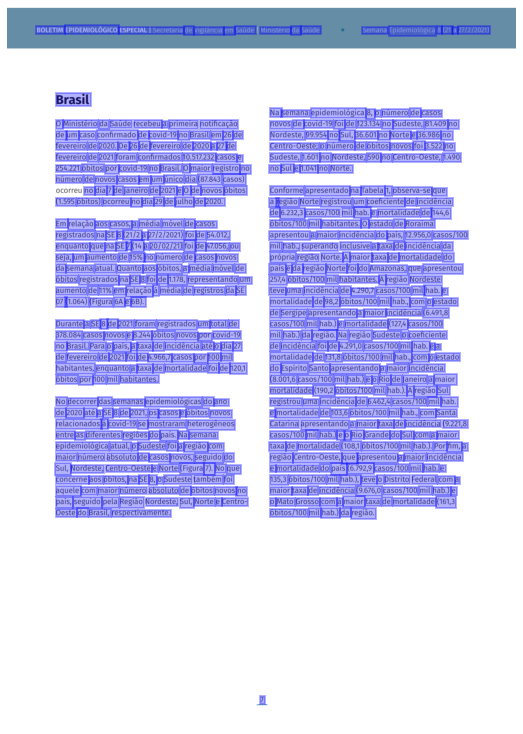

In [26]:
result.show(doc)

##### Print predicted text

In [27]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd(result.render())

BOLETIM EPIDEMIOLOGICO

ESPECIALISecretaria

Saude
de
Ministério
Vigilancia
Saude
em
da

Semana

a
8 (21
27/2/2021)

Epidemiologica

Brasil
Na
semana
numero
0
epidemiologica
de
casos
8,
Ministério
Saude
recebeu
0
a
da
primeira
notificaçao
covid-19
de
novos
123.134
de
foi
no
Sudeste,
81.409
no
de
de
covid-19
um
caso
confirmado
Brasil
de
no
em
99.954
26
36.601
Nordeste,
Norte
e
no
36.986
no
Sul,
no
fevereiro
fevereiro
de
2020.
De
26
de
de
2020
a
27
de
Centro-Oeste;
0
numero
de
obitos
novos
foi
3.522
no
fevereiro
confirmados
de
10.517.232
2021
foram
casos
e
Sudeste,
1.601
Nordeste,
590
Centro-Oeste,
no
1.490
no
254.221
obitos
covid-19
Brasil.
maior
no
0
e
no
por
Sul
1.041
no
no
Norte.
registro
numero
de
unico
novos
dia
casos
em
um
(87.843
casos)
dia
de
de
2021
no
e
de
7
janeiro
obitos
0
Conforme
novos
Tabela
observa-se
na
apresentado
1,
que
(1.595
obitos)
ocorreu
dia
29
de
de
2020.
no
Norte
julho
ar
regiao
de
registrou
incidência
um
coeficiente
de
e
mortalidade
casos/100
mil
de
hab.
6.232,3
144,6
média
Em
movel
aos
a
de
casos,
casos
habitantes.
relaçao
obitos/100
estado
mil
Roraima
0
de
8
na
SE
registrados
a
foi
de
54.012,
(21/2
a
maior
27/2/2021)
incidência
do
casos/100
apresentou
12.956,0
pais,
7
enquanto
a
20/02/21)
na
SE
que
de
47.056,
(14
ou
inclusive
foi
mil
hab.,
a
taxa
superando
de
incidência
da
aumento
de
15%
seja,
numero
um
de
casos
novos
no
mortalidade
Norte.
maior
taxa
regiao
de
A
propria
do
da
semana
atual.
média
Quanto
movel
aos
a
de
e
da
Norte
obitos,
foi
do
pais
Amazonas,
regiào
que
apresentou
obitos
8
SE
foi
de
representando
obitos/100
na
um
registrados
habitantes.
Nordeste
mil
1.178,
257,4
A
regiào
aumento
11%
em
média
de
de
registros
incidência
da
SE
à
teve
uma
relaçao
mil
de
casos/100
4.290,7
e
hab.
e
07
(Figura
6A
(1.064)
6B).
obitos/100
mortalidade
mil
de
0
estado
98,2
com
hab.,
incidência
de
a
maior
Sergipe
apresentando
(6.491,8
Durante
a
SE
de
um
2021
foram
8
total
de
mortalidade
casos/100
mil
registrados
e
casos/100
hab.)
(127,4
378.084
casos
novos
e
covid-19
8.244
obitos
novos
mil
hab.)
Sudeste
da
0
coeficiente
Na
por
regiào.
regiào
Brasil.
no
incidência
Para
0
até
0
a
taxa
de
incidência
dia
27
de
pais,
foi
de
4.291,0
e
a
casos/100
mil
hab.
fevereiro
de
2021
foi
de
de
100
mil
4.966,7
casos
de
obitos/100
mortalidade
por
mil
131,8
0
estado
com
hab.,
mortalidade
a
taxa
de
enquanto
foi
de
habitantes,
do
Santo
incidência
a
maior
120,1
Espirito
apresentando
habitantes.
obitos
100
mil
por
(8.001,6
casos/100
mil
hab.)
e
0
Rio
de
Janeiro
a
maior
mortalidade
obitos/100
mil
(190,2
Sul
hab.).
A
regiào
decorrer
das
No
semanas
do
ano
epidemiologicas
incidência
registrou
uma
mil
de
6.462,4
casos/100
hab.
de
até
a
8
de
e
obitos
SE
2021,
OS
2020
casos
e
novos
de
obitos/100
mortalidade
mil
103,6
Santa
com
hab.,
covid-19
relacionados
mostraram
à
se
Catarina
incidência
a
maior
heterogêneos
taxa
de
(9.221,8
apresentando
diferentes
entre
do
as
Na
semana
regioes
casos/100
Grande
mil
hab.)
pais.
Rio
do
Sul
com
e
0
a
maior
Sudeste
atual,
0
epidemiologica
foi
a
com
mortalidade
taxa
de
regiào
obitos/100
mil
hab.).
(108,1
Por
a
fim,
maior
numero
absoluto
de
casos
do
novos,
a
maior
incidencia
seguido
Centro-Oeste,
regiào
apresentou
que
Centro-Oeste
e
Nordeste,
Norte
e
mortalidade
No
Sul,
do
(Figura
casos/100
que
mil
hab.
e
7).
(6.792,9
pais
concerne
0
Sudeste
aos
obitos,
também
na
SE
foi
obitos/100
8,
mil
teve
Distrito
Federal
com
135,3
a
0
hab.),
numero
absoluto
com
maior
de
obitos
novos
aquele
incidencia
maior
taxa
de
no
casos/100
mil
hab.)
e
(9.676,0
Centro-
Nordeste,
Norte
e
seguido
0
pela
Mato
Regiào
Grosso
mortalidade
pais,
com
a
Sul,
taxa
de
maior
(161,3
Oeste
do
Brasil,
respectivamente.
mil
obitos/100
da
hab.)
regiào.

7

##### Get predicted words with coordinates and scores

In [28]:
json_output = result.export()
dict(list(json_output.items())[0:2])

{'pages': [{'blocks': [{'artefacts': [],
     'geometry': ((0.056640625, 0.0244140625), (0.21875, 0.0380859375)),
     'lines': [{'geometry': ((0.056640625, 0.0244140625),
        (0.21875, 0.0380859375)),
       'words': [{'confidence': 0.6669960618019104,
         'geometry': ((0.056640625, 0.0263671875),
          (0.1123046875, 0.0380859375)),
         'value': 'BOLETIM'},
        {'confidence': 0.9250790476799011,
         'geometry': ((0.1123046875, 0.0244140625), (0.21875, 0.0380859375)),
         'value': 'EPIDEMIOLOGICO'}]}]},
    {'artefacts': [],
     'geometry': ((0.2197265625, 0.02734375), (0.34765625, 0.0380859375)),
     'lines': [{'geometry': ((0.2197265625, 0.02734375),
        (0.34765625, 0.0380859375)),
       'words': [{'confidence': 0.2732674181461334,
         'geometry': ((0.2197265625, 0.02734375), (0.34765625, 0.0380859375)),
         'value': 'ESPECIALISecretaria'}]}]},
    {'artefacts': [],
     'geometry': ((0.34765625, 0.0263671875), (0.6162109375, 0.03906

In [29]:
# save
import unidecode
import json
doc_json = unidecode.unidecode(doc_name).lower().replace(' - ','_').replace(' ','_').replace('.pdf','.json')
path_to_doc_json = path_to_data + doc_json
with open(path_to_doc_json, 'w') as json_file:
    json.dump(json_output, json_file)

# load
import json
with open(path_to_doc_json) as json_file:
    json_output = json.load(json_file)

In [30]:
words_list = list()
xmin_list = list()
xmax_list = list()
ymin_list = list()
ymax_list = list()

for block in json_output['pages'][0]['blocks']:
  for line in block['lines']:
    for word in line['words']:

      # get coordonnates & word
      geometry = word['geometry']
      xmin = geometry[0][0]
      xmax = geometry[1][0]
      ymin = geometry[0][1]
      ymax = geometry[1][1]
      w = word['value']

      # get coordonnates and words lists without head and tail of the page
      if ymin >= 0.12 and ymax <= 0.71:
        xmin_list.append(xmin)
        xmax_list.append(xmax)
        ymin_list.append(ymin)
        ymax_list.append(ymax)
        words_list.append(w)

In [31]:
import pandas as pd
df = pd.DataFrame({'word':words_list,'xmin':xmin_list,'ymin':ymin_list, 'xmax':xmax_list, 'ymax':ymax_list})
df.head(15)

word      xmin      ymin      xmax      ymax
0           Brasil  0.095703  0.120117  0.164062  0.137695
1               Na  0.515625  0.140625  0.539062  0.153320
2           semana  0.538086  0.142578  0.594727  0.153320
3           numero  0.735352  0.141602  0.790039  0.152344
4                0  0.721680  0.143555  0.734375  0.153320
5   epidemiologica  0.596680  0.140625  0.704102  0.154297
6               de  0.791016  0.140625  0.812500  0.153320
7            casos  0.813477  0.142578  0.854492  0.153320
8               8,  0.704102  0.141602  0.721680  0.155273
9       Ministério  0.108398  0.156250  0.178711  0.167969
10           Saude  0.201172  0.156250  0.245117  0.167969
11         recebeu  0.248047  0.157227  0.303711  0.167969
12               0  0.094727  0.156250  0.109375  0.168945
13               a  0.304688  0.158203  0.315430  0.167969
14              da  0.179688  0.156250  0.200195  0.168945

### Run streamlit app from a Google Colab Notebook
> Created by [Manuel Romero](https://twitter.com/mrm8488)

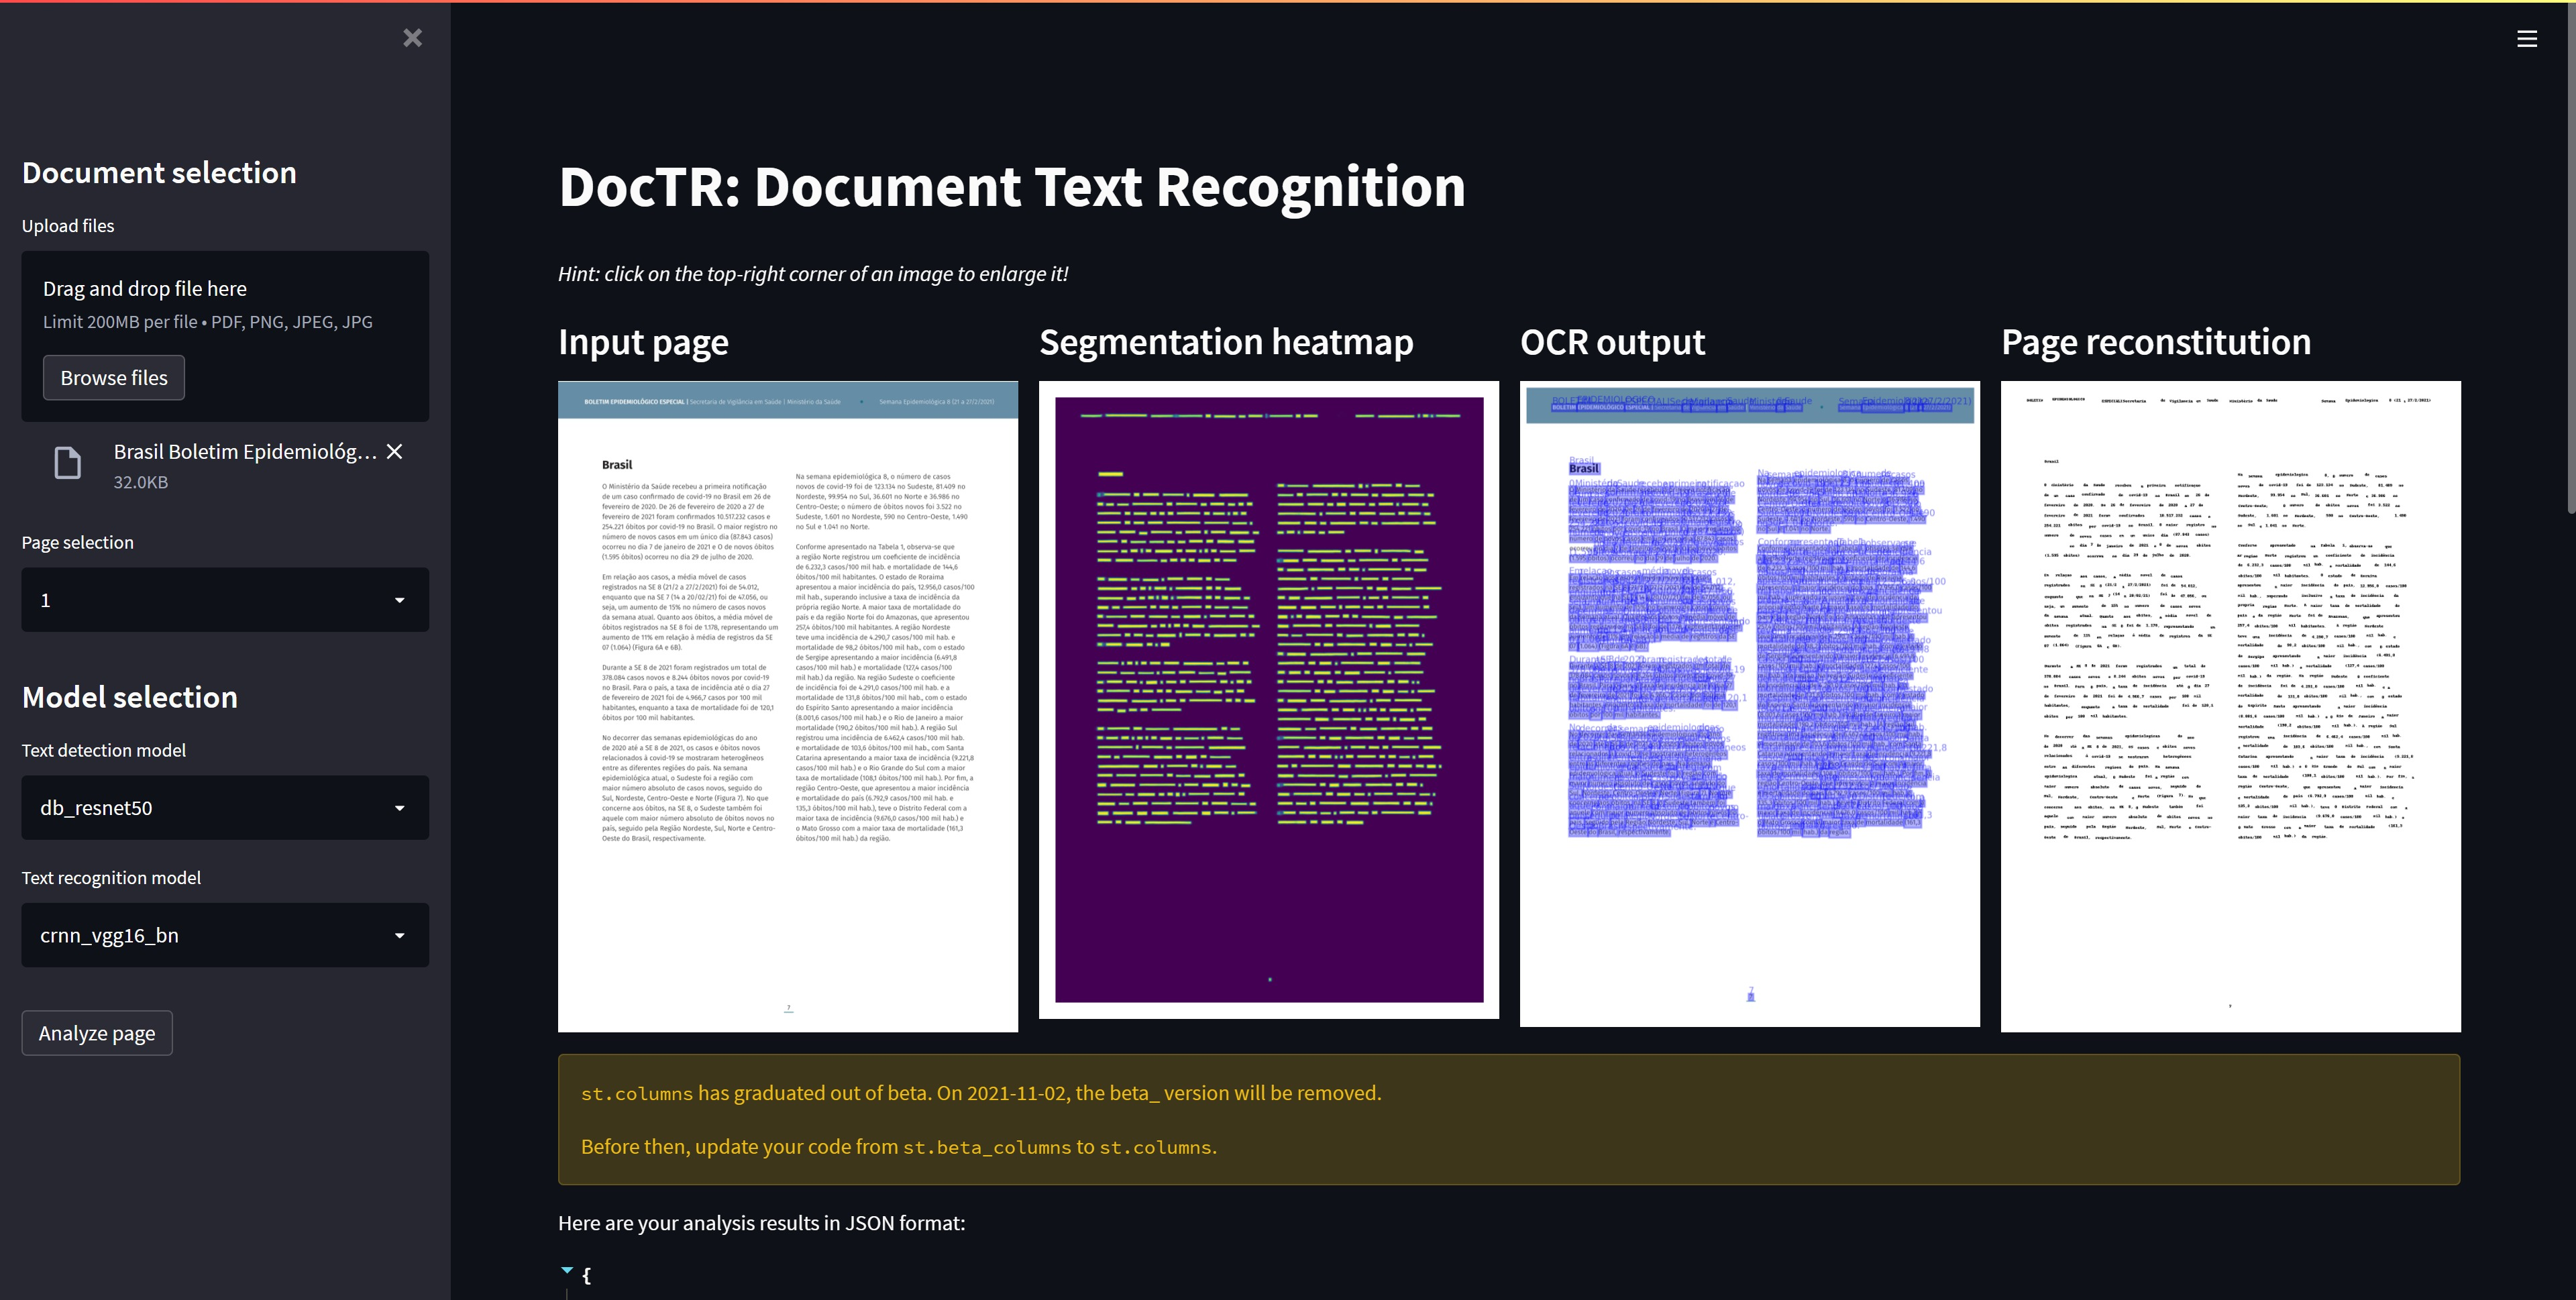

In [ ]:
%%capture
!pip install -q streamlit

Reset the execution environment after streamlit installation

In [ ]:
%%capture
# install the DocTR demo
!pip install -r doctr/demo/requirements.txt

#### Install ngrok

In [ ]:
%%capture
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

In [ ]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


#### App

Relaunch the 2 following cells if you don't get a text output with link like the following one: 

`Execute the next cell and the go to the following URL: https://...`

In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: https://3027-34-86-248-184.ngrok.io


In [ ]:
!streamlit run doctr/demo/app.py


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.86.248.184:8501

2021-10-02 10:18:23.334598: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-02 10:18:23.353 PyTorch version 1.9.0+cu102 available.
2021-10-02 10:18:23.355 TensorFlow version 2.6.0 available.
  Stopping...
  Stopping...


# END